# Plotting Bat Microbiome Data 

### Importing packages

In [67]:
import os
import sys
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull
import numpy as np
from scipy import stats
from itertools import combinations
from matplotlib.legend_handler import HandlerTuple
import matplotlib.lines as mlines
from scipy.stats import mannwhitneyu
from statsmodels.sandbox.stats.multicomp import multipletests

plt.style.use('default')

# OTU Data Table Import

In [70]:
condensed_otus_folder = "C:\\Users\\derek\\Documents\\Consultant_Work\\Cornell\\NMDS_Analysis\\78_bats_updated_taxonmy_uclust_05142025\\condensed_by_genera_log(x+1)"
files1 = os.listdir(condensed_otus_folder)

In [72]:
files1

['20250517_78bats_condensedOTUs_by_genera_nmds_summary.csv',
 '20250517_DiversityMetric_DiseaseStatus_CondensedOTUs_upodatedTaxa.png',
 '20250517_NMDS_BrayCurtis_DiseaseStatus_CondensedOTUs_updatedTaxa.png',
 '20250604_DiversityMetric_Season_CondensedOTUs_upodatedTaxa.png',
 'corrections with second matrix.txt',
 'mrpp_stats.txt',
 'nmds_output.csv',
 'nmds_summary.txt',
 'percent_of_variance_explained.txt',
 'row_and_summary_condensedgenus_raw.txt',
 'row_and_summary_results_log(x+1)_transformed_condensedgenus.txt']

In [74]:
for file in files1:
    if file.endswith("20250517_78bats_condensedOTUs_by_genera_nmds_summary.csv"):
        condense_data = pd.read_csv(os.path.join(condensed_otus_folder, file))

# Creating Plots NMDS Plots from PCORD Outputs

## Version 1 - Axis 1 vs Axis 2 with convex hull tracing DiseaseStatus
- MRPP results also from PCORD output

Group 'nan' has fewer than 2 points. Skipping hull/line for this group.


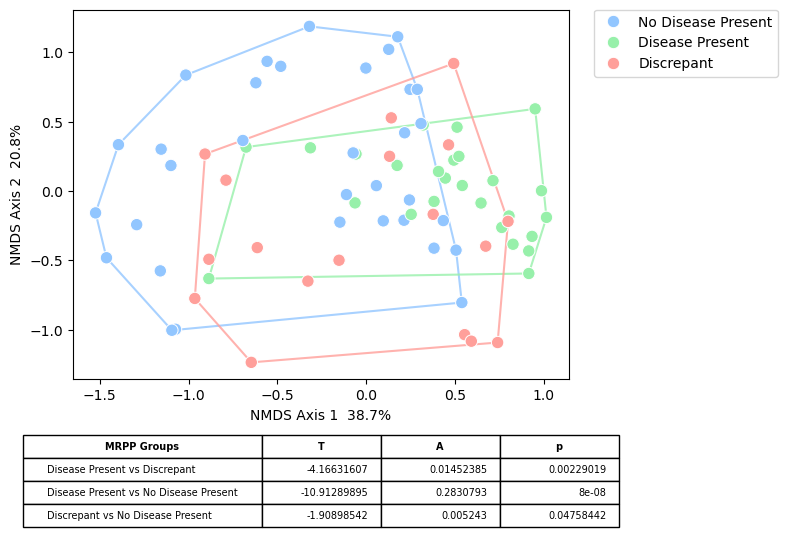

In [65]:
unique_groups = condense_data["DiseaseStatus"].unique()
palette = sns.color_palette(n_colors=len(unique_groups))
color_map = dict(zip(unique_groups, palette))

sns.scatterplot(data=condense_data, x="NMDS1", y="NMDS2", hue="DiseaseStatus", palette=color_map, s=80, zorder=3) # zorder=3 to draw points on top
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

for i, group in enumerate(unique_groups):
    group_points = condense_data[condense_data["DiseaseStatus"] == group][["NMDS1", "NMDS2"]].values

    if len(group_points) >= 3:
        try:
            hull = ConvexHull(group_points)
    
            # Get the vertices of the hull
            # hull.vertices gives indices of points in group_points forming the hull
            # hull.simplices gives pairs of indices for the edges
            for simplex in hull.simplices:
                 plt.plot(group_points[simplex, 0], group_points[simplex, 1], color=color_map[group], linestyle='-', linewidth=1.5, alpha=0.8, zorder=2) # Draw lines connecting vertices
         
        except Exception as e:
             # QhullError can happen with co-linear points
            print(f"Could not compute convex hull for group '{group}': {e}. Skipping hull for this group.")
            # Optionally plot the lines between points if hull fails but you still want some boundary
            if len(group_points) == 2:
                 plt.plot(group_points[:, 0], group_points[:, 1], color=color_map[group], linestyle='--', linewidth=1, alpha=0.6, zorder=2)

    elif len(group_points) == 2:
         # Draw a line between the two points if only two exist
         plt.plot(group_points[:, 0], group_points[:, 1], color=color_map[group], linestyle='--', linewidth=1, alpha=0.6, zorder=2)
         print(f"Group '{group}' has only 2 points. Drawing a line instead of a hull.")
    else:
        print(f"Group '{group}' has fewer than 2 points. Skipping hull/line for this group.")

plt.xlabel(f'NMDS Axis 1  38.7%') ## percents from PCORD analysis
plt.ylabel(f'NMDS Axis 2  20.8%')
# plt.title(f'NMDS (BrayCurtis) (Grouped by {"DisaseStatus"})')
# plt.ylim(-2.2,2.2)
# plt.xlim(-2.2,2.2)
plt.style.use('seaborn-v0_8-pastel')

# Adding MRPP results to table under graph - MRPP calculated in PCORD
data = {'MRPP Groups': ["Disease Present vs Discrepant", "Disease Present vs No Disease Present", "Discrepant vs No Disease Present"], 'T': [-4.16631607, -10.91289895, -1.90898542], 'A' : [0.01452385, 0.2830793, 0.00524300], 'p' : [0.00229019, 0.00000008, 0.04758442]}
df = pd.DataFrame(data)
table_data = [['MRPP Groups', 'T', 'A', 'p']] + df.values.tolist()

table_bbox = [-0.1, -0.4, 1.2, 0.25]
col_widths = [0.3, 0.15, 0.15, 0.15]
table = plt.table(cellText=table_data, cellLoc='center', colWidths=col_widths, bbox=table_bbox)



desired_font_size = 7 
table.auto_set_font_size(False)
table.set_fontsize(desired_font_size) 


for (row, col), cell in table.get_celld().items():
    if row == 0: # Header row
        cell.set_text_props(fontweight='bold')
    if row > 0: # Data rows
        if col > 0: # Numeric columns
             cell.set_text_props(ha='right')
        else: # Groups column
             cell.set_text_props(ha='left')

plt.savefig(os.path.join(condensed_otus_folder, "20250517_NMDS_BrayCurtis_DiseaseStatus_CondensedOTUs_updatedTaxa.png"), dpi=600, bbox_inches='tight')



## Version 2 - Axis 1 vs Axis 2, convex hull tracing from DiseaseStatus and custom markers for season group


Plot saved to plots\NMDS_Plot_CustomLegend_Spaced_FINAL.png


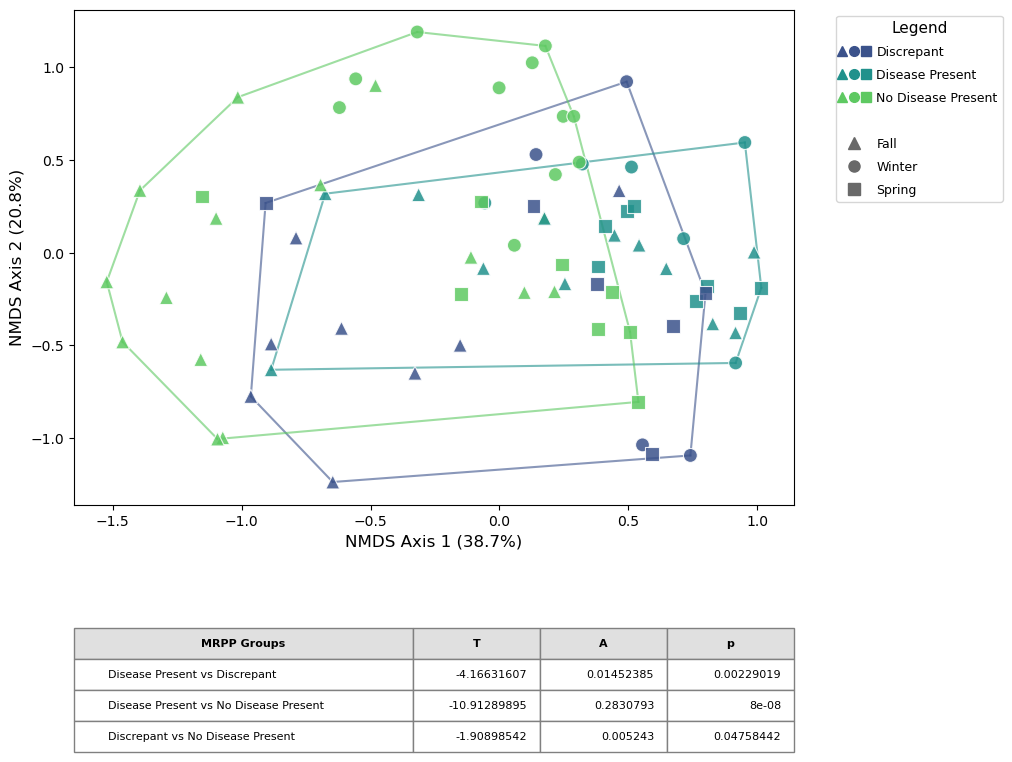

In [15]:

#1. Load the metadata file
metadata_file_path = "otu_metadata_uclust_updated_taxonomy_05162025.csv"
metadata_df = pd.read_csv(metadata_file_path)

#2. Load the NMDS summary data file 
nmds_file_path = "20250517_78bats_condensedOTUs_by_genera_nmds_summary.csv"
nmds_df = condense_data

#3. Clean and Extract NMDS data
nmds_df_cleaned = nmds_df.dropna(subset=['SampleID']).copy()
if not all(col in nmds_df_cleaned.columns for col in ['SampleID', 'NMDS1', 'NMDS2']):
    print("Error: 'SampleID', 'NMDS1', or 'NMDS2' column is missing from the NMDS data file after cleaning.")
    exit()
nmds_to_merge = nmds_df_cleaned[['SampleID', 'NMDS1', 'NMDS2']].copy()

#4. Prepare Metadata for Merge
actual_season_column_name = "Season"
if not all(col in metadata_df.columns for col in ['SampleID', 'DiseaseStatus', actual_season_column_name]):
    print(f"Error: 'SampleID', 'DiseaseStatus', or '{actual_season_column_name}' column is missing from the metadata file.")
    exit()
metadata_to_merge = metadata_df[['SampleID', 'DiseaseStatus', actual_season_column_name]].copy()

#5. Merge the DataFrames
condense_data = pd.merge(nmds_to_merge, metadata_to_merge, on='SampleID', how='inner')
if len(condense_data) == 0:
    print("Error: Merged DataFrame is empty. Please check that 'SampleID' values match.")
    exit()
condense_data.dropna(subset=['NMDS1', 'NMDS2', 'DiseaseStatus', actual_season_column_name], inplace=True)

#6. Plotting
condensed_otus_folder = "plots"
if not os.path.exists(condensed_otus_folder):
    os.makedirs(condensed_otus_folder)

plt.style.use('seaborn-v0_8-pastel')
fig, ax = plt.subplots(figsize=(12, 9))

unique_disease_groups = sorted(condense_data["DiseaseStatus"].unique())
palette_colors = sns.color_palette("viridis", n_colors=len(unique_disease_groups))
color_map = dict(zip(unique_disease_groups, palette_colors))

season_shape_map = {'Fall': '^', 'Winter': 'o', 'Spring': 's'}
unique_seasons_in_data = sorted(condense_data[actual_season_column_name].unique())

for season_val in unique_seasons_in_data:
    if season_val not in season_shape_map:
        print(f"Warning: Season value '{season_val}' found in data but not in 'season_shape_map'. Using default marker 'X'.")
        season_shape_map[season_val] = 'X'

sns.scatterplot(
    ax=ax,
    data=condense_data,
    x="NMDS1",
    y="NMDS2",
    hue="DiseaseStatus",
    style=actual_season_column_name,
    palette=color_map,
    hue_order=unique_disease_groups,
    style_order=unique_seasons_in_data,
    markers=season_shape_map,
    s=100,
    zorder=3,
    alpha=0.85,
    legend=False # Disable default legend
)

# Custom Legend Creation
legend_handles = []
legend_labels = []

# Disease Status Entries
for status in unique_disease_groups:
    color = color_map[status]
    label_text = status
    # Primary colored dot
    h_color_dot = mlines.Line2D([], [], color='w', marker='o', markerfacecolor=color, markersize=9, linestyle='None')
    # Shape markers in the disease status color
    h_triangle = mlines.Line2D([], [], color=color, marker='^', markersize=7, linestyle='None')
    h_circle   = mlines.Line2D([], [], color=color, marker='o', markersize=7, linestyle='None')
    h_square   = mlines.Line2D([], [], color=color, marker='s', markersize=7, linestyle='None')
    
    legend_handles.append((h_triangle, h_circle, h_square))
    legend_labels.append(label_text)

# Add a small spacer in the legend
legend_handles.append(mlines.Line2D([], [], linestyle='None')) 
legend_labels.append("") 

# Season Entries
season_legend_order = ['Fall', 'Winter', 'Spring'] 
actual_seasons_for_legend = [s for s in season_legend_order if s in unique_seasons_in_data]


for season_val in actual_seasons_for_legend:
    marker_shape = season_shape_map[season_val]
    h_season = mlines.Line2D([], [], color='dimgray', marker=marker_shape, markersize=8, linestyle='None')
    legend_handles.append(h_season)
    legend_labels.append(season_val)

# Create the legend with increased pad value for HandlerTuple
ax.legend(legend_handles, legend_labels,
          handler_map={tuple: HandlerTuple(ndivide=None, pad=0.9)}, ## pading, increase to space the shapes more. 
          bbox_to_anchor=(1.05, 1), loc='upper left',
          title="Legend", title_fontsize='11',
          fontsize='9', labelspacing=0.8)

# Convex Hulls to trace around each group - will need more than 2 entries to draw around a group
for group_name in unique_disease_groups:
    group_color = color_map[group_name]
    group_data_for_hull = condense_data[condense_data["DiseaseStatus"] == group_name]
    group_points_df = group_data_for_hull[["NMDS1", "NMDS2"]].dropna()
    group_points = group_points_df.values
    if len(group_points) >= 3:
        try:
            hull = ConvexHull(group_points)
            for simplex in hull.simplices:
                ax.plot(group_points[simplex, 0], group_points[simplex, 1], color=group_color, linestyle='-', linewidth=1.5, alpha=0.6, zorder=2)
        except Exception as e:
            print(f"Could not compute convex hull for group '{group_name}': {e}.")
            if len(group_points) >= 2:
                for j in range(len(group_points) - 1):
                    ax.plot([group_points[j,0], group_points[j+1,0]], [group_points[j,1], group_points[j+1,1]], color=group_color, linestyle='--', linewidth=1, alpha=0.5, zorder=2)
    elif len(group_points) == 2:
        ax.plot(group_points[:, 0], group_points[:, 1], color=group_color, linestyle='--', linewidth=1, alpha=0.6, zorder=2)

## Axis labels - values are from PCORD output.
ax.set_xlabel('NMDS Axis 1 (38.7%)', fontsize=12)
ax.set_ylabel('NMDS Axis 2 (20.8%)', fontsize=12)
# ax.set_title('NMDS by Disease Status and Season', fontsize=14, pad=20)

# MRPP Table - values from PCORD output, table will appear under the graph. 
data_table_content = {
    'MRPP Groups': ["Disease Present vs Discrepant", "Disease Present vs No Disease Present", "Discrepant vs No Disease Present"],
    'T': [-4.16631607, -10.91289895, -1.90898542],
    'A': [0.01452385, 0.2830793, 0.00524300],
    'p': [0.00229019, 0.00000008, 0.04758442]
}
df_table = pd.DataFrame(data_table_content)
table_data_list = [['MRPP Groups', 'T', 'A', 'p']] + df_table.values.tolist()
table_bbox = [0.0, -0.5, 1.0, 0.25]
col_widths = [0.4, 0.15, 0.15, 0.15]
table = ax.table(cellText=table_data_list, cellLoc='center', colWidths=col_widths, bbox=table_bbox)
desired_font_size = 8
table.auto_set_font_size(False)
table.set_fontsize(desired_font_size)
for (row, col), cell in table.get_celld().items():
    cell.set_edgecolor('grey')
    if row == 0:
        cell.set_text_props(fontweight='bold', color='black'); cell.set_facecolor('#e0e0e0')
    if row > 0:
        cell_text_obj = cell.get_text()
        if col > 0:
            cell_text_obj.set_ha('right')
            if df_table.columns[col-1] == 'p':
                 current_text = cell_text_obj.get_text()
                 try:
                     p_val = float(current_text)
                     if p_val < 0.001: cell_text_obj.set_text('$<$0.001')
                     else: cell_text_obj.set_text(f'{p_val:.4f}')
                 except ValueError: pass
        else: cell_text_obj.set_ha('left')

fig.subplots_adjust(left=0.1, right=0.70, top=0.90, bottom=0.35)
plot_filename = os.path.join(condensed_otus_folder, "NMDS_Plot_CustomLegend_Spaced_FINAL.png")
fig.savefig(plot_filename, dpi=600, bbox_inches='tight')
print(f"\nPlot saved to {plot_filename}")

plt.show()

## Version 2 - Axis 2 vs Axis 3 convex hull tracing from DiseaseStatus and custom markers for season group


Plot saved to plots\NMDS_Plot_CustomLegend_Spaced_Axis2_Axis3_FINAL.png


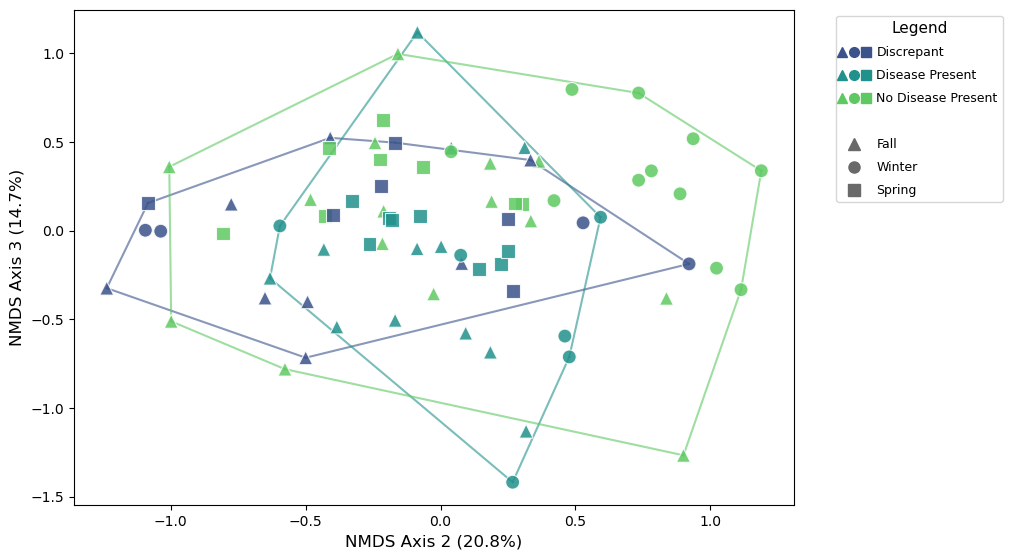

In [78]:
#1. Load the metadata file
metadata_file_path = "otu_metadata_uclust_updated_taxonomy_05162025.csv"
metadata_df1 = pd.read_csv(metadata_file_path)

#2. Load the NMDS data file
nmds_file_path = "20250517_78bats_condensedOTUs_by_genera_nmds_summary.csv"
nmds_df1 = condense_data

#3. Clean and Prepare NMDS data
nmds_df_cleaned1 = nmds_df1.dropna(subset=['SampleID']).copy()
if not all(col in nmds_df_cleaned1.columns for col in ['SampleID', 'NMDS2', 'NMDS3']):
    print("Error: 'SampleID', 'NMDS2', or 'NMDS3' column is missing from the NMDS data file after cleaning.")
    exit()
nmds_to_merge1 = nmds_df_cleaned1[['SampleID', 'NMDS2', 'NMDS3']].copy()

#4. Prepare Metadata for Merge
actual_season_column_name = "Season"
if not all(col in metadata_df1.columns for col in ['SampleID', 'DiseaseStatus', actual_season_column_name]):
    print(f"Error: 'SampleID', 'DiseaseStatus', or '{actual_season_column_name}' column is missing from the metadata file.")
    exit()
metadata_to_merge1 = metadata_df1[['SampleID', 'DiseaseStatus', actual_season_column_name]].copy()

#5. Merge the DataFrames
condense_data1 = pd.merge(nmds_to_merge1, metadata_to_merge1, on='SampleID', how='inner')
if len(condense_data) == 0:
    print("Error: Merged DataFrame is empty. Please check that 'SampleID' values match.")
    exit()
condense_data.dropna(subset=['NMDS2', 'NMDS3', 'DiseaseStatus', actual_season_column_name], inplace=True)

#6. Proceed with Plotting
condensed_otus_folder = "plots"
if not os.path.exists(condensed_otus_folder):
    os.makedirs(condensed_otus_folder)

plt.style.use('seaborn-v0_8-pastel')
fig, ax = plt.subplots(figsize=(12, 9))

unique_disease_groups = sorted(condense_data["DiseaseStatus"].unique())
palette_colors = sns.color_palette("viridis", n_colors=len(unique_disease_groups))
color_map = dict(zip(unique_disease_groups, palette_colors))

season_shape_map = {'Fall': '^', 'Winter': 'o', 'Spring': 's'}
unique_seasons_in_data = sorted(condense_data[actual_season_column_name].unique())

for season_val in unique_seasons_in_data:
    if season_val not in season_shape_map:
        print(f"Warning: Season value '{season_val}' found in data but not in 'season_shape_map'. Using default marker 'X'.")
        season_shape_map[season_val] = 'X'

sns.scatterplot(
    ax=ax,
    data=condense_data,
    x="NMDS2",
    y="NMDS3",
    hue="DiseaseStatus",
    style=actual_season_column_name,
    palette=color_map,
    hue_order=unique_disease_groups,
    style_order=unique_seasons_in_data,
    markers=season_shape_map,
    s=100,
    zorder=3,
    alpha=0.85,
    legend=False # Disable default legend
)

# Custom Legend Creation
legend_handles = []
legend_labels = []

# Disease Status Entries
for status in unique_disease_groups:
    color = color_map[status]
    label_text = status
    # Primary colored dot
    h_color_dot = mlines.Line2D([], [], color='w', marker='o', markerfacecolor=color, markersize=9, linestyle='None')
    # Shape markers in the disease status color
    h_triangle = mlines.Line2D([], [], color=color, marker='^', markersize=7, linestyle='None')
    h_circle   = mlines.Line2D([], [], color=color, marker='o', markersize=7, linestyle='None')
    h_square   = mlines.Line2D([], [], color=color, marker='s', markersize=7, linestyle='None')
    
    legend_handles.append((h_triangle, h_circle, h_square))
    legend_labels.append(label_text)

# Add a small spacer in the legend
legend_handles.append(mlines.Line2D([], [], linestyle='None')) 
legend_labels.append("") 

# Season Entries
season_legend_order = ['Fall', 'Winter', 'Spring'] 
actual_seasons_for_legend = [s for s in season_legend_order if s in unique_seasons_in_data]


for season_val in actual_seasons_for_legend:
    marker_shape = season_shape_map[season_val]
    h_season = mlines.Line2D([], [], color='dimgray', marker=marker_shape, markersize=8, linestyle='None')
    legend_handles.append(h_season)
    legend_labels.append(season_val)

# Create the legend with increased pad value for HandlerTuple
ax.legend(legend_handles, legend_labels,
          handler_map={tuple: HandlerTuple(ndivide=None, pad=0.9)}, ## pading, increase to space the shapes more. 
          bbox_to_anchor=(1.05, 1), loc='upper left',
          title="Legend", title_fontsize='11',
          fontsize='9', labelspacing=0.8)

# Convex Hulls
for group_name in unique_disease_groups:
    group_color = color_map[group_name]
    group_data_for_hull = condense_data[condense_data["DiseaseStatus"] == group_name]
    group_points_df = group_data_for_hull[["NMDS2", "NMDS3"]].dropna()
    group_points = group_points_df.values
    if len(group_points) >= 3:
        try:
            hull = ConvexHull(group_points)
            for simplex in hull.simplices:
                ax.plot(group_points[simplex, 0], group_points[simplex, 1], color=group_color, linestyle='-', linewidth=1.5, alpha=0.6, zorder=2)
        except Exception as e:
            print(f"Could not compute convex hull for group '{group_name}': {e}.")
            if len(group_points) >= 2:
                for j in range(len(group_points) - 1):
                    ax.plot([group_points[j,0], group_points[j+1,0]], [group_points[j,1], group_points[j+1,1]], color=group_color, linestyle='--', linewidth=1, alpha=0.5, zorder=2)
    elif len(group_points) == 2:
        ax.plot(group_points[:, 0], group_points[:, 1], color=group_color, linestyle='--', linewidth=1, alpha=0.6, zorder=2)

ax.set_xlabel('NMDS Axis 2 (20.8%)', fontsize=12)
ax.set_ylabel('NMDS Axis 3 (14.7%)', fontsize=12)
# ax.set_title('NMDS by Disease Status and Season', fontsize=14, pad=20)


fig.subplots_adjust(left=0.1, right=0.70, top=0.90, bottom=0.35)
plot_filename = os.path.join(condensed_otus_folder, "NMDS_Plot_CustomLegend_Spaced_Axis2_Axis3_FINAL.png")
fig.savefig(plot_filename, dpi=600, bbox_inches='tight')
print(f"\nPlot saved to {plot_filename}")

plt.show()

## Version 2 - Axis 1 vs Axis 3 convex hull tracing from DiseaseStatus and custom markers for season group


Plot saved to plots\NMDS_Plot_CustomLegend_Spaced_Axis1_Axis3_FINAL.png


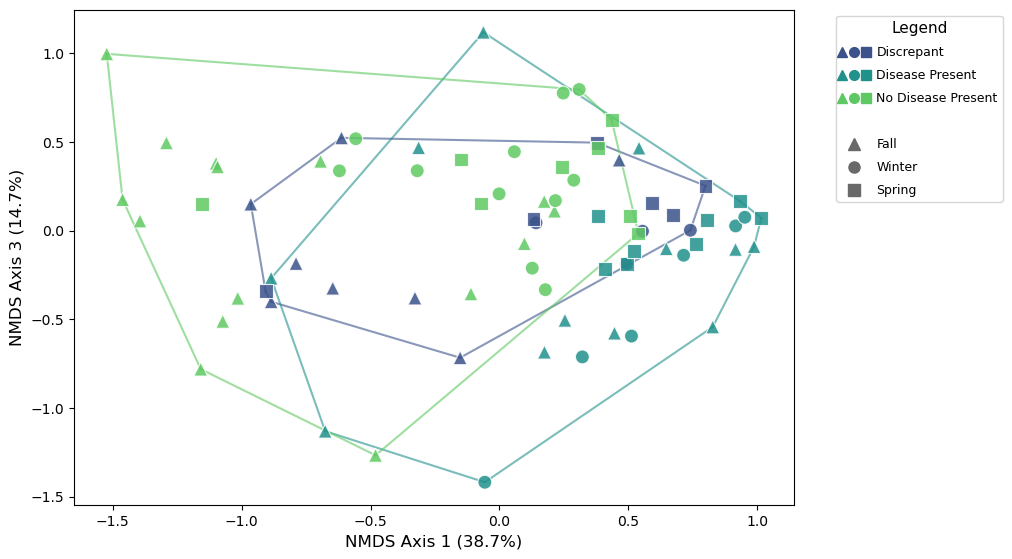

In [82]:
#1. Load the metadata file
metadata_file_path = "otu_metadata_uclust_updated_taxonomy_05162025.csv"
metadata_df2 = pd.read_csv(metadata_file_path)

#2. Load the NMDS data file
nmds_file_path = "20250517_78bats_condensedOTUs_by_genera_nmds_summary.csv"
nmds_df2 = condense_data

#3. Clean and Prepare NMDS data
nmds_df_cleaned2 = nmds_df2.dropna(subset=['SampleID']).copy()
if not all(col in nmds_df_cleaned2.columns for col in ['SampleID', 'NMDS1', 'NMDS3']):
    print("Error: 'SampleID', 'NMDS1', or 'NMDS3' column is missing from the NMDS data file after cleaning.")
    exit()
nmds_to_merge2 = nmds_df_cleaned2[['SampleID', 'NMDS1', 'NMDS3']].copy()

#4. Prepare Metadata for Merge
actual_season_column_name = "Season"
if not all(col in metadata_df2.columns for col in ['SampleID', 'DiseaseStatus', actual_season_column_name]):
    print(f"Error: 'SampleID', 'DiseaseStatus', or '{actual_season_column_name}' column is missing from the metadata file.")
    exit()
metadata_to_merge2 = metadata_df2[['SampleID', 'DiseaseStatus', actual_season_column_name]].copy()

#5. Merge the DataFrames
condense_data = pd.merge(nmds_to_merge2, metadata_to_merge2, on='SampleID', how='inner')
if len(condense_data) == 0:
    print("Error: Merged DataFrame is empty. Please check that 'SampleID' values match.")
    exit()
condense_data.dropna(subset=['NMDS1', 'NMDS3', 'DiseaseStatus', actual_season_column_name], inplace=True)

#6. Proceed with Plotting
condensed_otus_folder = "plots"
if not os.path.exists(condensed_otus_folder):
    os.makedirs(condensed_otus_folder)

plt.style.use('seaborn-v0_8-pastel')
fig, ax = plt.subplots(figsize=(12, 9))

unique_disease_groups = sorted(condense_data["DiseaseStatus"].unique())
palette_colors = sns.color_palette("viridis", n_colors=len(unique_disease_groups))
color_map = dict(zip(unique_disease_groups, palette_colors))

season_shape_map = {'Fall': '^', 'Winter': 'o', 'Spring': 's'}
unique_seasons_in_data = sorted(condense_data[actual_season_column_name].unique())

for season_val in unique_seasons_in_data:
    if season_val not in season_shape_map:
        print(f"Warning: Season value '{season_val}' found in data but not in 'season_shape_map'. Using default marker 'X'.")
        season_shape_map[season_val] = 'X'

sns.scatterplot(
    ax=ax,
    data=condense_data,
    x="NMDS1",
    y="NMDS3",
    hue="DiseaseStatus",
    style=actual_season_column_name,
    palette=color_map,
    hue_order=unique_disease_groups,
    style_order=unique_seasons_in_data,
    markers=season_shape_map,
    s=100,
    zorder=3,
    alpha=0.85,
    legend=False # Disable default legend
)

# Custom Legend Creation
legend_handles = []
legend_labels = []

# Disease Status Entries
for status in unique_disease_groups:
    color = color_map[status]
    label_text = status
    # Primary colored dot
    h_color_dot = mlines.Line2D([], [], color='w', marker='o', markerfacecolor=color, markersize=9, linestyle='None')
    # Shape markers in the disease status color
    h_triangle = mlines.Line2D([], [], color=color, marker='^', markersize=7, linestyle='None')
    h_circle   = mlines.Line2D([], [], color=color, marker='o', markersize=7, linestyle='None')
    h_square   = mlines.Line2D([], [], color=color, marker='s', markersize=7, linestyle='None')
    
    legend_handles.append((h_triangle, h_circle, h_square))
    legend_labels.append(label_text)

# Add a small spacer in the legend
legend_handles.append(mlines.Line2D([], [], linestyle='None')) 
legend_labels.append("") 

# Season Entries
season_legend_order = ['Fall', 'Winter', 'Spring'] 
actual_seasons_for_legend = [s for s in season_legend_order if s in unique_seasons_in_data]


for season_val in actual_seasons_for_legend:
    marker_shape = season_shape_map[season_val]
    h_season = mlines.Line2D([], [], color='dimgray', marker=marker_shape, markersize=8, linestyle='None')
    legend_handles.append(h_season)
    legend_labels.append(season_val)

# Create the legend with increased pad value for HandlerTuple
ax.legend(legend_handles, legend_labels,
          handler_map={tuple: HandlerTuple(ndivide=None, pad=0.9)}, ## pading, increase to space the shapes more. 
          bbox_to_anchor=(1.05, 1), loc='upper left',
          title="Legend", title_fontsize='11',
          fontsize='9', labelspacing=0.8)

# Convex Hulls
for group_name in unique_disease_groups:
    group_color = color_map[group_name]
    group_data_for_hull = condense_data[condense_data["DiseaseStatus"] == group_name]
    group_points_df = group_data_for_hull[["NMDS1", "NMDS3"]].dropna()
    group_points = group_points_df.values
    if len(group_points) >= 3:
        try:
            hull = ConvexHull(group_points)
            for simplex in hull.simplices:
                ax.plot(group_points[simplex, 0], group_points[simplex, 1], color=group_color, linestyle='-', linewidth=1.5, alpha=0.6, zorder=2)
        except Exception as e:
            print(f"Could not compute convex hull for group '{group_name}': {e}.")
            if len(group_points) >= 2:
                for j in range(len(group_points) - 1):
                    ax.plot([group_points[j,0], group_points[j+1,0]], [group_points[j,1], group_points[j+1,1]], color=group_color, linestyle='--', linewidth=1, alpha=0.5, zorder=2)
    elif len(group_points) == 2:
        ax.plot(group_points[:, 0], group_points[:, 1], color=group_color, linestyle='--', linewidth=1, alpha=0.6, zorder=2)

ax.set_xlabel('NMDS Axis 1 (38.7%)', fontsize=12)
ax.set_ylabel('NMDS Axis 3 (14.7%)', fontsize=12)
# ax.set_title('NMDS by Disease Status and Season', fontsize=14, pad=20)


fig.subplots_adjust(left=0.1, right=0.70, top=0.90, bottom=0.35)
plot_filename = os.path.join(condensed_otus_folder, "NMDS_Plot_CustomLegend_Spaced_Axis1_Axis3_FINAL.png")
fig.savefig(plot_filename, dpi=600, bbox_inches='tight')
print(f"\nPlot saved to {plot_filename}")

plt.show()

# Plotting Diversity of Summary Stats
- Output from row and summary stats in PCORD

### data file imports

In [12]:
for file in files1:
    if file.endswith("20250517_78bats_condensedOTUs_by_genera_nmds_summary.csv"):
        condense_summary_data = pd.read_csv(os.path.join(condensed_otus_folder, file))

## Alpha Diversity - Grouped by DiseaseStatus

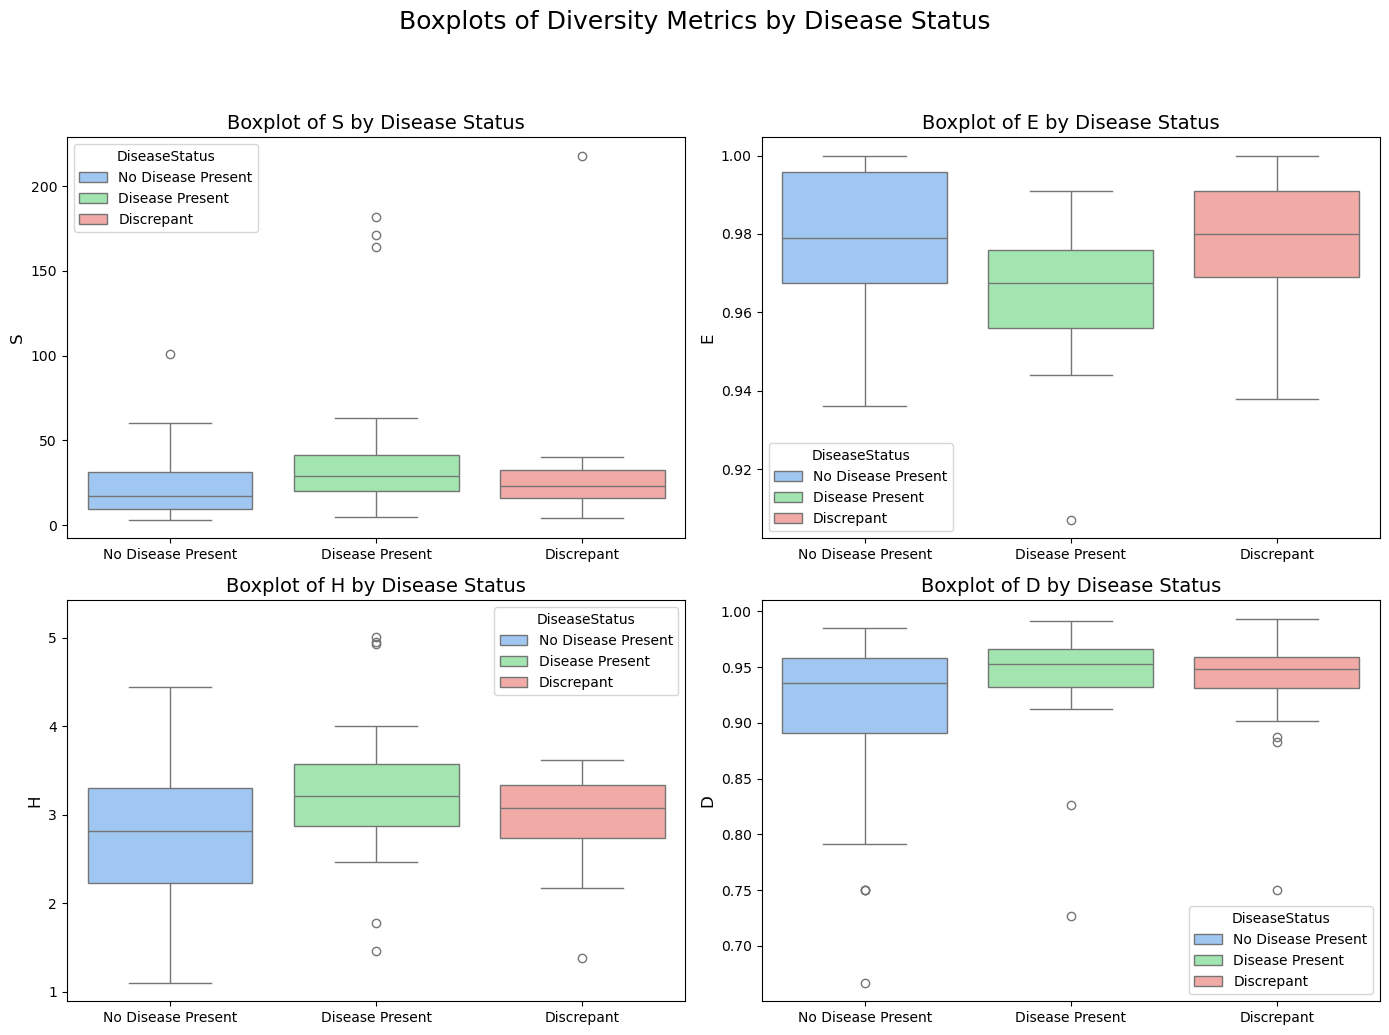

In [16]:
columns_to_plot = ['S', 'E', 'H', 'D']
grouping_variable = 'DiseaseStatus'
status_order = ['No Disease Present', 'Disease Present', 'Discrepant']
# status_order = ['Disease Present', 'No Disease Present', 'Discrepant']

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(columns_to_plot):
    sns.boxplot(x=grouping_variable,
                y=col,
                data=condense_summary_data,
                ax=axes[i],
                # palette="Set2", # Color palette
                order=status_order, hue="DiseaseStatus") # Ensure consistent order of groups
    axes[i].set_title(f'Boxplot of {col} by Disease Status', fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel(col, fontsize=12)
    # axes[i].tick_params(axis='x', rotation=15) # Rotate x-labels slightly if long

# Add an overall title to the figure
fig.suptitle('Boxplots of Diversity Metrics by Disease Status', fontsize=18, y=1.03)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust rect to make space for suptitle
plt.style.use('seaborn-v0_8-pastel')
plt.savefig(os.path.join(condensed_otus_folder, "20250517_DiversityMetric_DiseaseStatus_CondensedOTUs_upodatedTaxa.png"), dpi=600, bbox_inches='tight')

### Calculating Pairwise Comparisons using non parametric tests
script does the following:
- loads data, looks for S, E, H, D columns, and drops any zeros
- Determine number of unique Disease groups
- Apply Kruskal-Wallis (if >2 groups) or Mann-Whitney U (if 2 groups)
- If Kruskal-Wallis is significant, then perform pairwise Mann-Whitney U tests with a Bonferroni correction to adjust P-values for multiple comparisons

In [49]:
col_s_actual = 'S'     # Placeholder for 'S' (e.g., Observed OTUs, Richness)
col_e_actual = 'E'     # Placeholder for 'E' (e.g., Pielou's Evenness, Shannon Evenness)
col_h_actual = 'H'     # Placeholder for 'H' (e.g., Shannon Diversity Index)
col_d_actual = 'D'     # Placeholder for 'D' (e.g., Simpson Diversity Index)

grouping_variable_actual = 'DiseaseStatus' # Placeholder for your grouping variable column
# List of the actual column names for which to perform tests
metrics_to_test = [col_s_actual, col_e_actual, col_h_actual, col_d_actual]

# Verify if specified columns exist
missing_cols = []
for col in metrics_to_test + [grouping_variable_actual]:
    if col not in condense_summary_data.columns and col.startswith('YOUR_'): # Check if still a placeholder
        missing_cols.append(col)
    elif col not in condense_summary_data.columns: # Check if user-defined name is missing
        missing_cols.append(f"{col} (user-specified)")

if missing_cols:
    print(f"Error: The following specified columns were not found in the DataFrame: {missing_cols}")
    print("Please update the placeholder variables (col_s_actual, etc., and grouping_variable_actual)")
    print("in the script with the correct column names from your CSV file (see printed column list above).")
    exit()


# Data Cleaning and Preparation
df_cleaned = condense_summary_data.dropna(subset=[grouping_variable_actual] + metrics_to_test).copy() # Use .copy() to avoid SettingWithCopyWarning

# Convert metric columns to numeric, coercing errors
for col in metrics_to_test:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
df_cleaned = df_cleaned.dropna(subset=metrics_to_test) # Drop again if to_numeric created NaNs

if df_cleaned.empty:
    print("Error: DataFrame is empty after cleaning. Please check your data and column specifications.")
    exit()

# Get unique categories for the grouping variable
group_categories = sorted(df_cleaned[grouping_variable_actual].unique())
num_groups = len(group_categories)

print(f"\nFound {num_groups} groups in '{grouping_variable_actual}': {group_categories}")
print(f"Number of data points after cleaning: {len(df_cleaned)}\n")


# Perform Statistical Tests
alpha = 0.05 # Significance level

for metric in metrics_to_test:
    print(f"--- Testing for metric: {metric} ---")

    # Prepare data for scipy.stats functions: a list of arrays, one for each group
    grouped_data = [df_cleaned[df_cleaned[grouping_variable_actual] == group][metric].dropna().values for group in group_categories]
    
    # Filter out any empty groups that might result from excessive NaNs in a specific metric column for a group
    valid_grouped_data = [g for g in grouped_data if len(g) > 0]
    valid_group_categories = [cat for i, cat in enumerate(group_categories) if len(grouped_data[i]) > 0]

    current_num_groups = len(valid_grouped_data)

    if current_num_groups < 2:
        print(f"Not enough groups with data for metric '{metric}' to perform a test (found {current_num_groups}). Skipping.\n")
        continue

    if current_num_groups == 2:
        # Mann-Whitney U test
        group1_data = valid_grouped_data[0]
        group2_data = valid_grouped_data[1]
        if len(group1_data) > 0 and len(group2_data) > 0:
            try:
                u_statistic, p_value = stats.mannwhitneyu(group1_data, group2_data, alternative='two-sided')
                print(f"Mann-Whitney U test for {valid_group_categories[0]} vs {valid_group_categories[1]}:")
                print(f"  U-statistic = {u_statistic:.4f}, P-value = {p_value:.4f}")
                if p_value < alpha:
                    print(f"  Result: Significant difference found (p < {alpha}).")
                else:
                    print(f"  Result: No significant difference found (p >= {alpha}).")
            except ValueError as e: # Can occur if one group has all same values
                 print(f"  Could not perform Mann-Whitney U test for {valid_group_categories[0]} vs {valid_group_categories[1]}: {e}")
        else:
            print("  Not enough data in one or both groups for Mann-Whitney U test after filtering.")

    elif current_num_groups > 2:
        # Kruskal-Wallis H test
        try:
            h_statistic, p_value = stats.kruskal(*valid_grouped_data)
            print(f"Kruskal-Wallis H test across {current_num_groups} groups ({', '.join(valid_group_categories)}):")
            print(f"  H-statistic = {h_statistic:.4f}, P-value = {p_value:.4f}")

            if p_value < alpha:
                print(f"  Result: Significant difference found among groups (p < {alpha}). Performing post-hoc tests...")

                # Post-hoc: Pairwise Mann-Whitney U tests with Bonferroni correction
                comparisons = list(combinations(range(current_num_groups), 2))
                num_comparisons = len(comparisons)
                bonferroni_alpha = alpha / num_comparisons
                print(f"  Bonferroni corrected alpha for post-hoc tests: {bonferroni_alpha:.4f}")

                significant_pairs_found = False
                for i, j in comparisons:
                    group1_name = valid_group_categories[i]
                    group2_name = valid_group_categories[j]
                    group1_data = valid_grouped_data[i]
                    group2_data = valid_grouped_data[j]
                    
                    if len(group1_data) > 0 and len(group2_data) > 0:
                        try:
                            posthoc_u, posthoc_p = stats.mannwhitneyu(group1_data, group2_data, alternative='two-sided')
                            print(f"    - Pairwise Mann-Whitney U ({group1_name} vs {group2_name}): P-value = {posthoc_p:.4f}")
                            if posthoc_p < bonferroni_alpha:
                                print(f"      Significant difference after Bonferroni correction (p < {bonferroni_alpha:.4f}).")
                                significant_pairs_found = True
                        except ValueError as e:
                             print(f"    - Could not perform Mann-Whitney U test for {group1_name} vs {group2_name}: {e}")

                    else:
                        print(f"    - Skipping {group1_name} vs {group2_name} due to insufficient data in one group.")
                
                if not significant_pairs_found and num_comparisons > 0 :
                     print("    No specific pairs found significantly different after Bonferroni correction.")


            else:
                print(f"  Result: No significant difference found among groups (p >= {alpha}).")
        except ValueError as e: # Can occur if all values in one group are identical
            print(f"  Could not perform Kruskal-Wallis test: {e}")
            
    print("-" * 30 + "\n")

print("\n--- Statistical Testing Finished ---")
print("Interpretation Notes:")
print(f"- A P-value less than the significance level (alpha = {alpha}) suggests that the observed differences are statistically significant.")
print("- For Kruskal-Wallis, a significant result means at least one group is different from at least one other group.")
print("- Post-hoc tests (like pairwise Mann-Whitney U with Bonferroni) help identify which specific pairs of groups differ.")
print("- Bonferroni correction is a conservative method to control for Type I errors (false positives) when making multiple comparisons.")


Found 3 groups in 'DiseaseStatus': ['Discrepant', 'Disease Present', 'No Disease Present']
Number of data points after cleaning: 78

--- Testing for metric: S ---
Kruskal-Wallis H test across 3 groups (Discrepant, Disease Present, No Disease Present):
  H-statistic = 5.1320, P-value = 0.0768
  Result: No significant difference found among groups (p >= 0.05).
------------------------------

--- Testing for metric: E ---
Kruskal-Wallis H test across 3 groups (Discrepant, Disease Present, No Disease Present):
  H-statistic = 9.4540, P-value = 0.0089
  Result: Significant difference found among groups (p < 0.05). Performing post-hoc tests...
  Bonferroni corrected alpha for post-hoc tests: 0.0167
    - Pairwise Mann-Whitney U (Discrepant vs Disease Present): P-value = 0.0232
    - Pairwise Mann-Whitney U (Discrepant vs No Disease Present): P-value = 0.5824
    - Pairwise Mann-Whitney U (Disease Present vs No Disease Present): P-value = 0.0043
      Significant difference after Bonferroni 

## Alpha Diversity - Grouped by Season

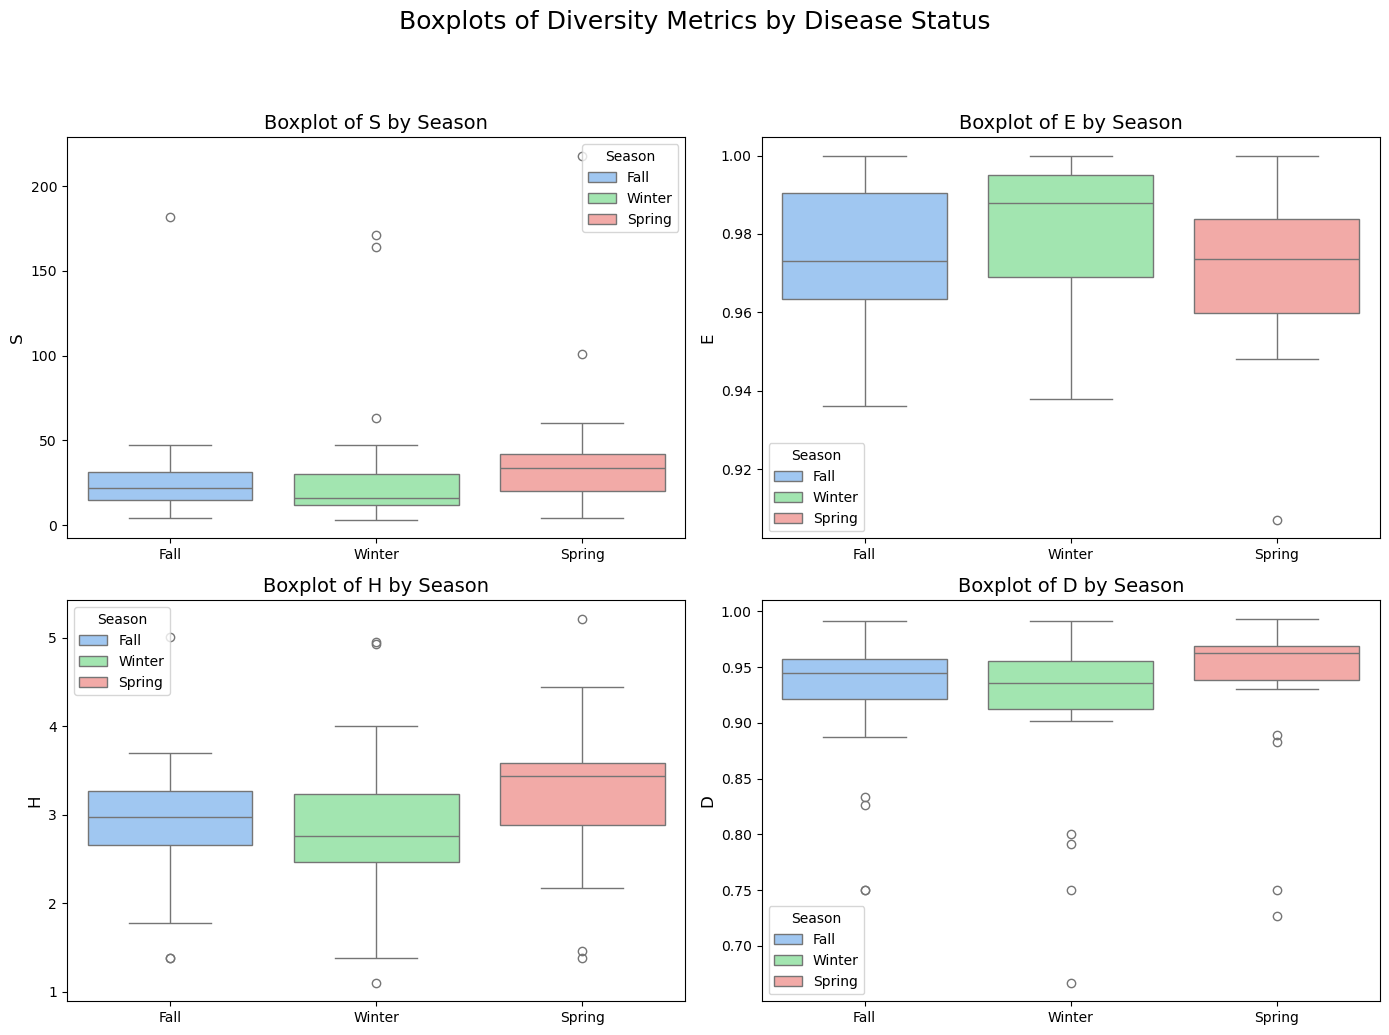

In [233]:
columns_to_plot = ['S', 'E', 'H', 'D']
grouping_variable = 'Season'
status_order = ['Fall', 'Winter', 'Spring']


# Create a figure with 2x2 subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(columns_to_plot):
    sns.boxplot(x=grouping_variable,
                y=col,
                data=condense_summary_data,
                ax=axes[i],
                # palette="Set2", # Color palette
                order=status_order, hue="Season") # Ensure consistent order of groups
    axes[i].set_title(f'Boxplot of {col} by Season', fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel(col, fontsize=12)
    # axes[i].tick_params(axis='x', rotation=15) # Rotate x-labels slightly if long

# Add an overall title to the figure
fig.suptitle('Boxplots of Diversity Metrics by Disease Status', fontsize=18, y=1.03)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust rect to make space for suptitle
plt.style.use('seaborn-v0_8-pastel')
plt.savefig(os.path.join(condensed_otus_folder, "20250604_DiversityMetric_Season_CondensedOTUs_upodatedTaxa.png"), dpi=600, bbox_inches='tight')

# Stacked Bar Plots of Taxa at Domain Level 

## All Taxa

Processing OTU table: otu_table_uclust_with_updated_taxonomy_05172025_78bats_singletsRemoved_78bats.csv
Using metadata: otu_metadata_uclust_updated_taxonomy_05162025.csv
Successfully loaded OTU table: 'otu_table_uclust_with_updated_taxonomy_05172025_78bats_singletsRemoved_78bats.csv' (Shape: (1939, 88))
Successfully loaded metadata: 'otu_metadata_uclust_updated_taxonomy_05162025.csv' (Shape: (78, 26))
Identified OTU sample columns: 78
Unique processed domains from OTU table: 5

Stacked bar plot saved to 'domain_abundance_grouped_diseaseStatus_78bats_FINAL.png'


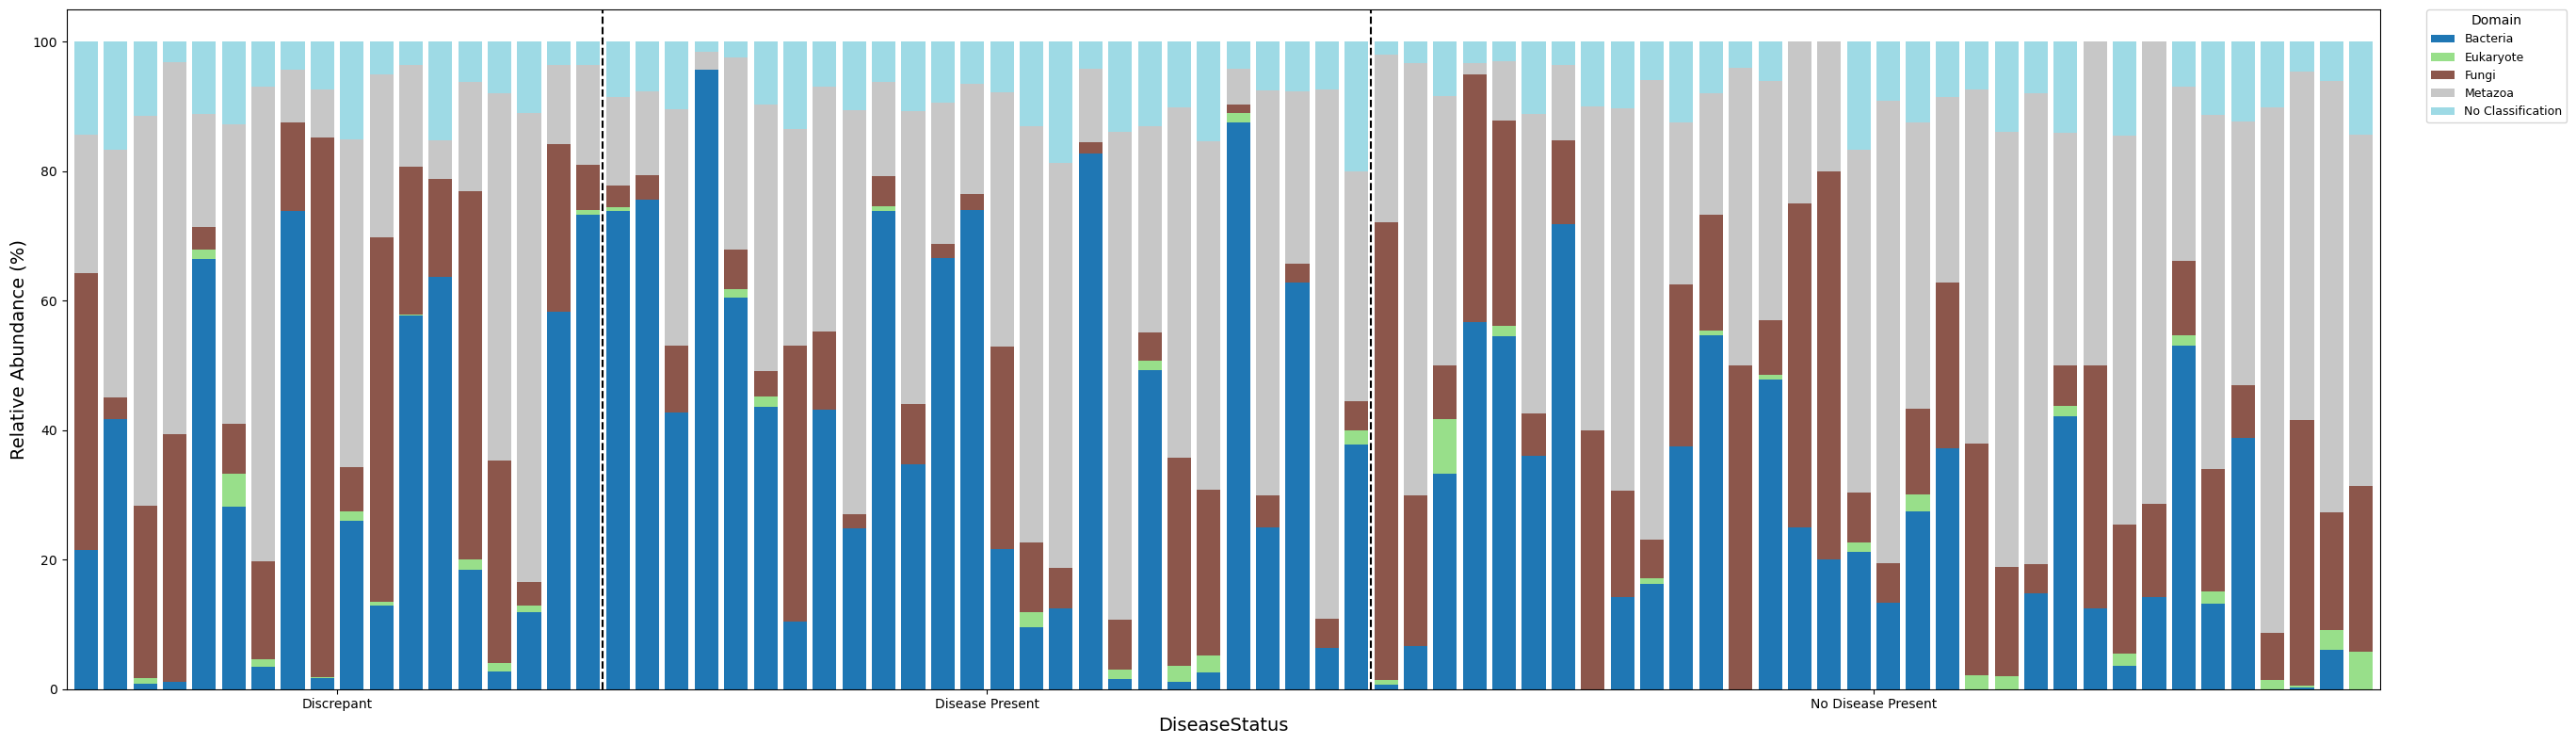

Script finished.


In [37]:
def extract_domain_from_taxonomy_string(taxonomy_string):
    """
    Extracts the domain (highest taxonomic rank) from a full taxonomy string.
    - Treats unassigned, no blast hit, no hit, and unknown as unassigned taxa
    """
    if pd.isna(taxonomy_string) or not isinstance(taxonomy_string, str) or taxonomy_string.strip() == "":
        return "Unassigned"
    
    taxonomy_string = taxonomy_string.strip()

    if "chimera" in taxonomy_string.lower():
        return "Possible Chimera"
    if taxonomy_string.lower() in ["unassigned", "no blast hit", "no hit", "unknown"]:
        return "Unassigned"

    parts = taxonomy_string.split(';')
    if not parts:
        return "Unassigned"
    
    domain_part = parts[0].strip()
    domain_part = re.sub(r'\s*\(.+?\)\s*$', '', domain_part)
    domain_part = re.sub(r'\s*\[.+?\]\s*$', '', domain_part)
    
    return domain_part if domain_part else "Unassigned"

def plot_domain_relative_abundance_grouped(
        otu_table_csv_path, 
        metadata_csv_path,
        metadata_sample_id_col="#SampleID", 
        metadata_grouping_col="DiseaseStatus", 
        otu_domain_col="Domain", 
        output_plot_path="domain_relative_abundance_grouped_plot_simplified_x.png"
    ):
    """
    Reads an OTU table and metadata, calculates domain relative abundance,
    and generates a stacked bar plot grouped by a metadata column, with simplified x-axis labels.
    """
    try:
        df_otu = pd.read_csv(otu_table_csv_path)
        print(f"Successfully loaded OTU table: '{otu_table_csv_path}' (Shape: {df_otu.shape})")
    except FileNotFoundError:
        print(f"Error: OTU table file '{otu_table_csv_path}' not found.")
        return
    except Exception as e:
        print(f"Error loading OTU table CSV: {e}")
        return

    try:
        df_metadata = pd.read_csv(metadata_csv_path)
        print(f"Successfully loaded metadata: '{metadata_csv_path}' (Shape: {df_metadata.shape})")
    except FileNotFoundError:
        print(f"Error: Metadata file '{metadata_csv_path}' not found.")
        return
    except Exception as e:
        print(f"Error loading metadata CSV: {e}")
        return

    if df_otu.empty or df_metadata.empty:
        print("One or both DataFrames are empty. Cannot proceed.")
        return

    # Validate metadata columns
    if metadata_sample_id_col not in df_metadata.columns:
        print(f"Error: Metadata Sample ID column '{metadata_sample_id_col}' not found in metadata file.")
        return
    if metadata_grouping_col not in df_metadata.columns:
        print(f"Error: Metadata grouping column '{metadata_grouping_col}' not found in metadata file.")
        return
    
    df_metadata[metadata_sample_id_col] = df_metadata[metadata_sample_id_col].astype(str)
    df_metadata[metadata_grouping_col] = df_metadata[metadata_grouping_col].fillna('UnknownStatus').astype(str)


    # Process OTU Table
    sample_column_pattern = re.compile(r'^[A-Z]\d{2}$')
    sample_columns_otu = [col for col in df_otu.columns if sample_column_pattern.match(col)]

    if not sample_columns_otu:
        print(f"Error: No sample columns matching pattern '[A-Z]\\d{{2}}' found in OTU table '{otu_table_csv_path}'.")
        return
    print(f"Identified OTU sample columns: {len(sample_columns_otu)}")

    if otu_domain_col not in df_otu.columns:
        print(f"Error: OTU domain column '{otu_domain_col}' not found in OTU table.")
        return
    
    for col in sample_columns_otu:
        df_otu[col] = pd.to_numeric(df_otu[col], errors='coerce')
    df_otu[sample_columns_otu] = df_otu[sample_columns_otu].fillna(0)

    df_otu['Processed_Domain'] = df_otu[otu_domain_col].apply(extract_domain_from_taxonomy_string)
    print(f"Unique processed domains from OTU table: {df_otu['Processed_Domain'].nunique()}")

    domain_abundances_abs = df_otu.groupby('Processed_Domain')[sample_columns_otu].sum()

    # Filter and Order Samples based on Metadata
    group_mapping = pd.Series(df_metadata[metadata_grouping_col].values, index=df_metadata[metadata_sample_id_col]).to_dict()

    samples_to_plot_info = []
    for sample_id in domain_abundances_abs.columns: # Iterate over columns from OTU table (sample IDs)
        if sample_id in group_mapping:
            samples_to_plot_info.append({'SampleID': sample_id, 'Group': group_mapping[sample_id]})
        else:
            print(f"Warning: SampleID '{sample_id}' from OTU table not found in metadata. It will be excluded.")
    
    if not samples_to_plot_info:
        print("Error: No samples from the OTU table were found in the metadata or all were excluded. Cannot create plot.")
        return
        
    df_sample_order = pd.DataFrame(samples_to_plot_info)
    df_sample_order.sort_values(by=['Group', 'SampleID'], inplace=True) # Sort by group, then by SampleID within group
    
    sorted_sample_ids = df_sample_order['SampleID'].tolist()
    
    domain_abundances_abs_sorted = domain_abundances_abs[sorted_sample_ids]

    sample_totals = domain_abundances_abs_sorted.sum(axis=0)
    sample_totals[sample_totals == 0] = 1 
    
    relative_abundances = domain_abundances_abs_sorted.div(sample_totals, axis=1) * 100

    if relative_abundances.empty:
        print("No data to plot after processing and filtering. Check inputs and column names.")
        return

    # Plotting
    plt.style.use('seaborn-v0_8-pastel') 
    data_to_plot = relative_abundances.T # Transpose: Samples as rows (index), Domains as columns

    fig, ax = plt.subplots(figsize=(max(12, len(sorted_sample_ids) * 0.4), 8)) # Adjusted width factor
    
    # Plot the bars. The x-axis will be 0, 1, 2... for each sample
    data_to_plot.plot(kind='bar', stacked=True, ax=ax, colormap='tab20', width=0.8)

    # ax.set_title(f'Relative Abundance of Domains (Grouped by {metadata_grouping_col})', fontsize=16)
    ax.set_xlabel(metadata_grouping_col, fontsize=14) # X-axis title is now the grouping category
    ax.set_ylabel('Relative Abundance (%)', fontsize=14)
    
    # Custom X-axis Tick Labels and Positions
    group_positions = []
    group_labels = []
    
    # Find the positions for group labels
    current_group_name = None
    group_start_idx = 0
    for i, sample_id in enumerate(sorted_sample_ids):
        # Get group for the current sample_id from the sorted df_sample_order
        sample_group = df_sample_order[df_sample_order['SampleID'] == sample_id]['Group'].iloc[0]
        
        if current_group_name is None: # First sample
            current_group_name = sample_group
            group_start_idx = i
        elif sample_group != current_group_name: # New group starts
            # Calculate midpoint for the previous group
            group_end_idx = i - 1
            group_positions.append((group_start_idx + group_end_idx) / 2.0)
            group_labels.append(current_group_name)
            
            # Add vertical line - MODIFIED FOR BOLDER APPEARANCE
            ax.axvline(x=i - 0.5, color='black', linestyle='--', linewidth=1.5) # Increased linewidth, changed color
            
            # Reset for new group
            current_group_name = sample_group
            group_start_idx = i
            
    # Add the last group's label
    if current_group_name is not None:
        group_end_idx = len(sorted_sample_ids) - 1
        group_positions.append((group_start_idx + group_end_idx) / 2.0)
        group_labels.append(current_group_name)

    ax.set_xticks(group_positions)
    ax.set_xticklabels(group_labels, rotation=0, ha='center', fontsize=10)
    # Remove minor ticks that might appear due to bar plotting
    ax.minorticks_off()


    ax.legend(title='Domain', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=9)
    
    fig.tight_layout(rect=[0, 0, 0.88, 1]) 

    try:
        plt.savefig(output_plot_path, bbox_inches='tight', dpi=600)
        print(f"\nStacked bar plot saved to '{output_plot_path}'")
        plt.show()
    except Exception as e:
        print(f"Error saving plot: {e}")

if __name__ == "__main__":
    otu_file = "otu_table_uclust_with_updated_taxonomy_05172025_78bats_singletsRemoved_78bats.csv"
    meta_file = "otu_metadata_uclust_updated_taxonomy_05162025.csv"
    
    metadata_sample_col = "SampleID" 
    metadata_group_col = "DiseaseStatus"
    otu_taxonomy_col = "Domain"

    output_plot_file = "domain_abundance_grouped_diseaseStatus_78bats_FINAL.png"
    
    if not os.path.exists(otu_file):
        print(f"CRITICAL ERROR: The OTU table file '{otu_file}' was not found.")
    elif not os.path.exists(meta_file):
        print(f"CRITICAL ERROR: The metadata file '{meta_file}' was not found.")
    else:
        print(f"Processing OTU table: {otu_file}")
        print(f"Using metadata: {meta_file}")
        plot_domain_relative_abundance_grouped(
            otu_table_csv_path=otu_file,
            metadata_csv_path=meta_file,
            metadata_sample_id_col=metadata_sample_col,
            metadata_grouping_col=metadata_group_col,
            otu_domain_col=otu_taxonomy_col,
            output_plot_path=output_plot_file
        )
        print("Script finished.")


## Bat Microbiome at Phylum Level 
- metazoa has been removed
- no classification has been removed

Processing OTU table: otu_table_uclust_with_updated_taxonomy_05172025_78bats_singletsRemoved_78bats_filtered_domains.csv
Using metadata: otu_metadata_uclust_updated_taxonomy_05162025.csv
Successfully loaded OTU table: 'otu_table_uclust_with_updated_taxonomy_05172025_78bats_singletsRemoved_78bats_filtered_domains.csv' (Shape: (1511, 88))
Successfully loaded metadata: 'otu_metadata_uclust_updated_taxonomy_05162025.csv' (Shape: (78, 26))
Identified OTU sample columns: 78
Unique processed plotting taxa ('Phylum'): 20
Unique legend grouping taxa ('Domain'): 3

Stacked bar plot with grouped legend saved to 'phylum_abundance_legend_grouped_by_domain_tab20.png'


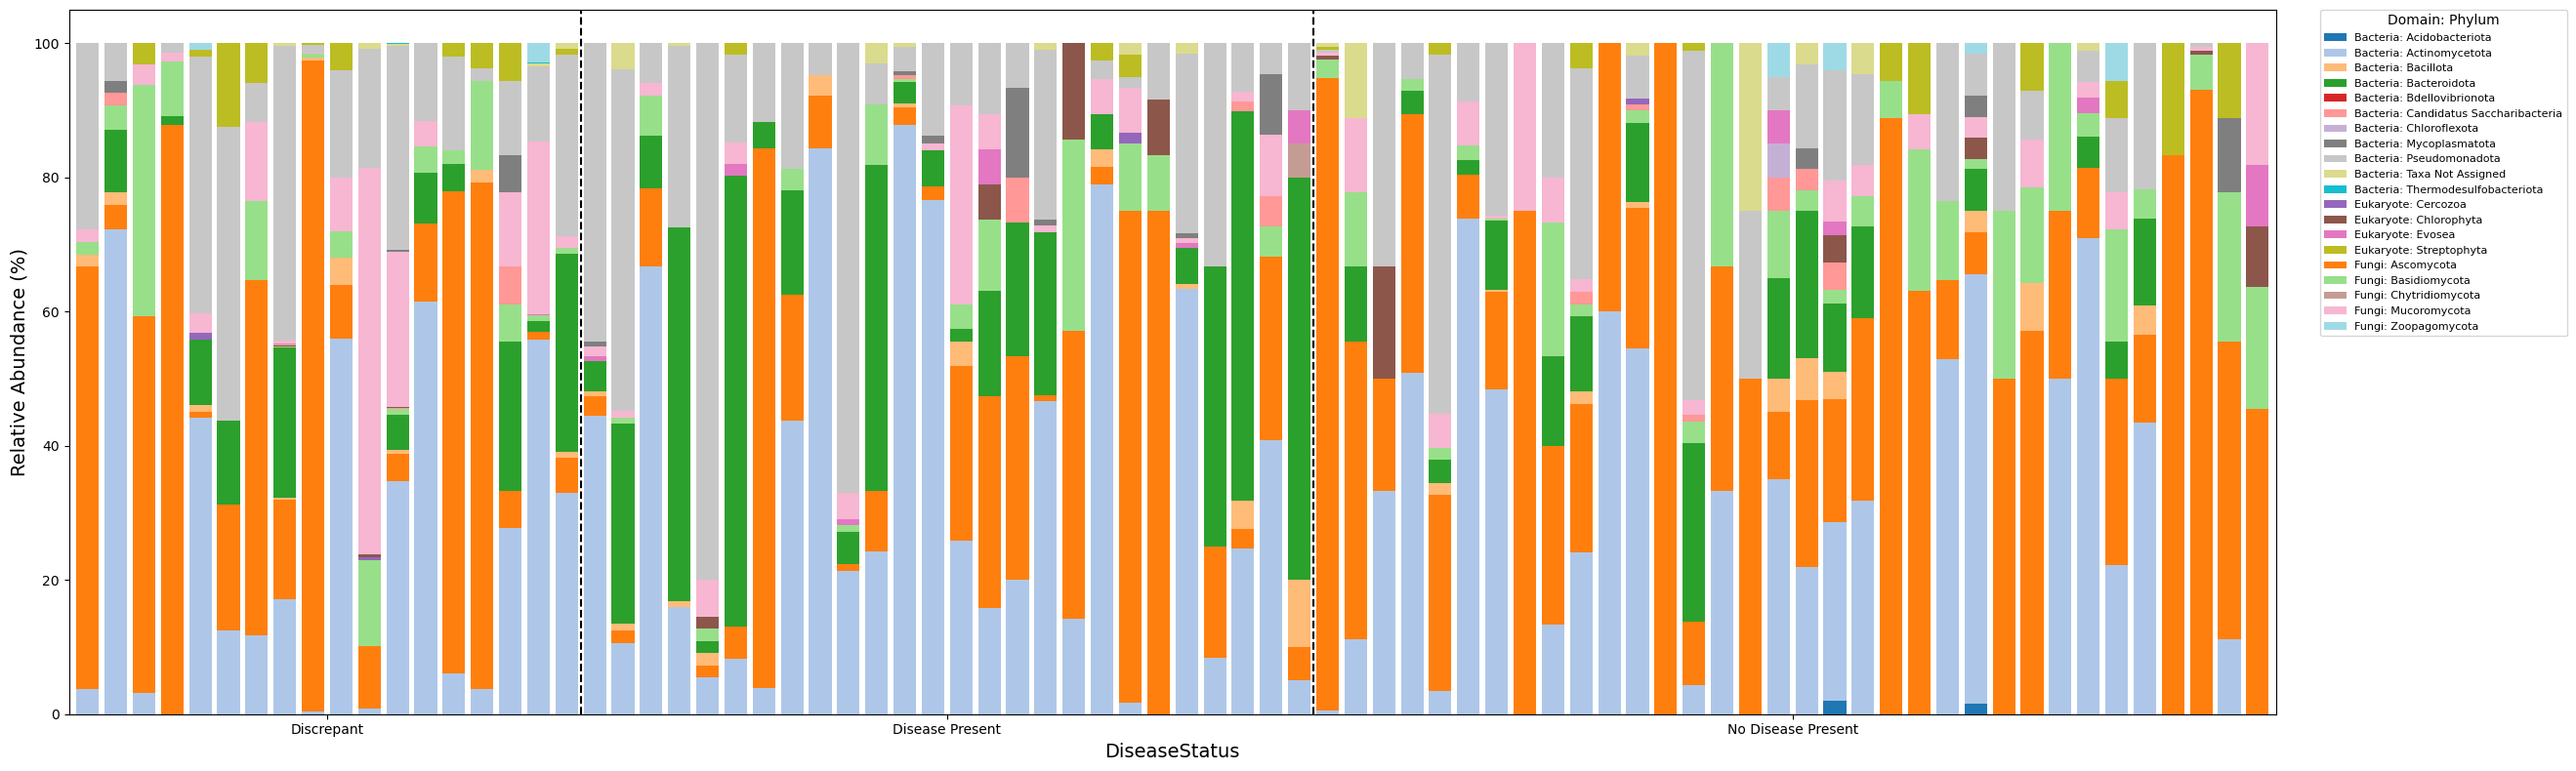

Script finished.


In [41]:
def extract_domain_from_taxonomy_string(taxonomy_string): # This processes the Phylum string
    """
    Cleans up a taxonomy string (e.g., Phylum name).
    """
    if pd.isna(taxonomy_string) or not isinstance(taxonomy_string, str) or taxonomy_string.strip() == "":
        return "Unassigned" # Or "Unknown Phylum"
    
    taxonomy_string = taxonomy_string.strip()

    # If the string is already simple (e.g. "Proteobacteria"), these regexes won't harm it.
    # Remove qualifiers like (superkingdom), (phylum) etc.
    taxonomy_string = re.sub(r'\s*\(.+?\)\s*$', '', taxonomy_string)
    taxonomy_string = re.sub(r'\s*\[.+?\]\s*$', '', taxonomy_string)
    
    return taxonomy_string if taxonomy_string else "Unassigned"


def plot_phylum_relative_abundance_grouped_legend( # Renamed function for clarity
        otu_table_csv_path, 
        metadata_csv_path,
        metadata_sample_id_col="#SampleID", 
        metadata_grouping_col="DiseaseStatus", 
        otu_plotting_level_col="Phylum", # The taxonomic level to plot
        otu_legend_group_col="Domain", # The higher taxonomic level for legend grouping
        output_plot_path="phylum_relative_abundance_grouped_legend.png"
    ):
    """
    Reads an OTU table and metadata, calculates relative abundance of a target taxonomic level,
    and generates a stacked bar plot grouped by a metadata column,
    Uses 'tab20' colormap for better distinction between taxa.
    """
    try:
        df_otu = pd.read_csv(otu_table_csv_path)
        print(f"Successfully loaded OTU table: '{otu_table_csv_path}' (Shape: {df_otu.shape})")
    except FileNotFoundError:
        print(f"Error: OTU table file '{otu_table_csv_path}' not found.")
        return
    except Exception as e:
        print(f"Error loading OTU table CSV: {e}")
        return

    try:
        df_metadata = pd.read_csv(metadata_csv_path)
        print(f"Successfully loaded metadata: '{metadata_csv_path}' (Shape: {df_metadata.shape})")
    except FileNotFoundError:
        print(f"Error: Metadata file '{metadata_csv_path}' not found.")
        return
    except Exception as e:
        print(f"Error loading metadata CSV: {e}")
        return

    if df_otu.empty or df_metadata.empty:
        print("One or both DataFrames are empty. Cannot proceed.")
        return

    # Validate metadata and OTU table columns
    if metadata_sample_id_col not in df_metadata.columns:
        print(f"Error: Metadata Sample ID column '{metadata_sample_id_col}' not found in metadata file.")
        return
    if metadata_grouping_col not in df_metadata.columns:
        print(f"Error: Metadata grouping column '{metadata_grouping_col}' not found in metadata file.")
        return
    if otu_plotting_level_col not in df_otu.columns:
        print(f"Error: OTU plotting level column '{otu_plotting_level_col}' not found in OTU table.")
        return
    if otu_legend_group_col not in df_otu.columns:
        print(f"Error: OTU legend grouping column '{otu_legend_group_col}' not found in OTU table. This is needed for the grouped legend.")
        return
        
    df_metadata[metadata_sample_id_col] = df_metadata[metadata_sample_id_col].astype(str)
    df_metadata[metadata_grouping_col] = df_metadata[metadata_grouping_col].fillna('UnknownStatus').astype(str)

    # Process OTU Table
    sample_column_pattern = re.compile(r'^[A-Z]\d{2}$')
    sample_columns_otu = [col for col in df_otu.columns if sample_column_pattern.match(col)]

    if not sample_columns_otu:
        print(f"Error: No sample columns matching pattern '[A-Z]\\d{{2}}' found in OTU table '{otu_table_csv_path}'.")
        return
    print(f"Identified OTU sample columns: {len(sample_columns_otu)}")
    
    for col in sample_columns_otu:
        df_otu[col] = pd.to_numeric(df_otu[col], errors='coerce')
    df_otu[sample_columns_otu] = df_otu[sample_columns_otu].fillna(0)

    # Process the taxonomic level to be plotted
    df_otu['Processed_Plot_Taxon'] = df_otu[otu_plotting_level_col].apply(extract_domain_from_taxonomy_string) # Using existing function to clean names
    # Ensure the legend grouping column (Domain) is also clean (string, no NaNs)
    df_otu[otu_legend_group_col] = df_otu[otu_legend_group_col].fillna('Unknown_Domain').astype(str).apply(extract_domain_from_taxonomy_string)


    print(f"Unique processed plotting taxa ('{otu_plotting_level_col}'): {df_otu['Processed_Plot_Taxon'].nunique()}")
    print(f"Unique legend grouping taxa ('{otu_legend_group_col}'): {df_otu[otu_legend_group_col].nunique()}")

    taxon_to_legend_group_map = df_otu.groupby('Processed_Plot_Taxon')[otu_legend_group_col].first().to_dict()
    taxon_abundances_abs = df_otu.groupby('Processed_Plot_Taxon')[sample_columns_otu].sum()

    # Filter and Order Samples based on Metadata
    group_mapping = pd.Series(df_metadata[metadata_grouping_col].values, index=df_metadata[metadata_sample_id_col]).to_dict()
    samples_to_plot_info = []
    for sample_id in taxon_abundances_abs.columns: 
        if sample_id in group_mapping:
            samples_to_plot_info.append({'SampleID': sample_id, 'Group': group_mapping[sample_id]})
        else:
            print(f"Warning: SampleID '{sample_id}' from OTU table not found in metadata. It will be excluded.")
    
    if not samples_to_plot_info:
        print("Error: No samples from OTU table found in metadata. Cannot create plot.")
        return
            
    df_sample_order = pd.DataFrame(samples_to_plot_info)
    df_sample_order.sort_values(by=['Group', 'SampleID'], inplace=True)
    sorted_sample_ids = df_sample_order['SampleID'].tolist()
    
    taxon_abundances_abs_sorted = taxon_abundances_abs[sorted_sample_ids]
    sample_totals = taxon_abundances_abs_sorted.sum(axis=0)
    sample_totals[sample_totals == 0] = 1 
    relative_abundances = taxon_abundances_abs_sorted.div(sample_totals, axis=1) * 100

    if relative_abundances.empty:
        print("No data to plot after processing and filtering. Check inputs and column names.")
        return

    # Plotting
    plt.style.use('seaborn-v0_8-pastel') 
    data_to_plot = relative_abundances.T 

    fig, ax = plt.subplots(figsize=(max(12, len(sorted_sample_ids) * 0.4), 8))
    # MODIFIED: Changed colormap to 'tab20'
    data_to_plot.plot(kind='bar', stacked=True, ax=ax, colormap='tab20', width=0.8, legend=False) 

    # ax.set_title(f'Relative Abundance of {otu_plotting_level_col} (Grouped by {metadata_grouping_col})', fontsize=16)
    ax.set_xlabel(metadata_grouping_col, fontsize=14)
    ax.set_ylabel('Relative Abundance (%)', fontsize=14)
    
    group_positions, group_labels_x_axis = [], []
    current_group_name, group_start_idx = None, 0
    for i, sample_id in enumerate(sorted_sample_ids):
        sample_group = df_sample_order[df_sample_order['SampleID'] == sample_id]['Group'].iloc[0]
        if current_group_name is None: 
            current_group_name, group_start_idx = sample_group, i
        elif sample_group != current_group_name: 
            group_positions.append((group_start_idx + i - 1) / 2.0)
            group_labels_x_axis.append(current_group_name)
            ax.axvline(x=i - 0.5, color='black', linestyle='--', linewidth=1.5)
            current_group_name, group_start_idx = sample_group, i
    if current_group_name is not None:
        group_positions.append((group_start_idx + len(sorted_sample_ids) - 1) / 2.0)
        group_labels_x_axis.append(current_group_name)

    ax.set_xticks(group_positions)
    ax.set_xticklabels(group_labels_x_axis, rotation=0, ha='center', fontsize=10)
    ax.minorticks_off()

    # Custom Grouped Legend
    handles, plot_level_labels = ax.get_legend_handles_labels() 
    
    legend_entries = []
    for handle, plot_taxon_label in zip(handles, plot_level_labels):
        legend_group_name = taxon_to_legend_group_map.get(plot_taxon_label, "Unknown " + otu_legend_group_col)
        legend_entries.append({
            'legend_group': legend_group_name, 
            'plot_taxon': plot_taxon_label, 
            'handle': handle,
            'display_label': f"{legend_group_name}: {plot_taxon_label}" 
        })

    sorted_legend_entries = sorted(legend_entries, key=lambda x: (x['legend_group'], x['plot_taxon']))

    new_handles = [entry['handle'] for entry in sorted_legend_entries]
    new_display_labels = [entry['display_label'] for entry in sorted_legend_entries]
    
    ax.legend(new_handles, new_display_labels, 
              title=f'{otu_legend_group_col}: {otu_plotting_level_col}', 
              bbox_to_anchor=(1.02, 1), loc='upper left', 
              borderaxespad=0., fontsize=8) 
    
    fig.tight_layout(rect=[0, 0, 0.85, 1]) 

    try:
        plt.savefig(output_plot_path, bbox_inches='tight', dpi=600)
        print(f"\nStacked bar plot with grouped legend saved to '{output_plot_path}'")
        plt.show()
    except Exception as e:
        print(f"Error saving plot: {e}")

if __name__ == "__main__":
    otu_file = "otu_table_uclust_with_updated_taxonomy_05172025_78bats_singletsRemoved_78bats_filtered_domains.csv" 
    meta_file = "otu_metadata_uclust_updated_taxonomy_05162025.csv" 
    
    metadata_sample_id_col = "SampleID"  
    metadata_grouping_col = "DiseaseStatus" 
    
    plotting_level_column = "Phylum" 
    legend_grouping_column = "Domain" 

    output_plot_file = "phylum_abundance_legend_grouped_by_domain_tab20.png" # Updated filename
    
    if not os.path.exists(otu_file):
        print(f"CRITICAL ERROR: The OTU table file '{otu_file}' was not found.")
    elif not os.path.exists(meta_file):
        print(f"CRITICAL ERROR: The metadata file '{meta_file}' was not found.")
    else:
        print(f"Processing OTU table: {otu_file}")
        print(f"Using metadata: {meta_file}")
        plot_phylum_relative_abundance_grouped_legend( 
            otu_table_csv_path=otu_file,
            metadata_csv_path=meta_file,
            metadata_sample_id_col=metadata_sample_col,
            metadata_grouping_col=metadata_grouping_col,
            otu_plotting_level_col=plotting_level_column, 
            otu_legend_group_col=legend_grouping_column, 
            output_plot_path=output_plot_file
        )
        print("Script finished.")


# Ratio of Bacteria and Fungal Relative Abundances

## Plot with DiseaseStatus Grouping

--- Processing OTU Table and Metadata for B/F Ratios ---
Processing OTU table: otu_table_uclust_with_updated_taxonomy_05172025_78bats_singletsRemoved_78bats_filtered_domains_combined_by_genus_keep_blanks_species_column_removed.csv
Using metadata: otu_metadata_uclust_updated_taxonomy_05162025.csv
Successfully loaded OTU table: 'otu_table_uclust_with_updated_taxonomy_05172025_78bats_singletsRemoved_78bats_filtered_domains_combined_by_genus_keep_blanks_species_column_removed.csv' (Shape: (617, 88))
Successfully loaded metadata: 'otu_metadata_uclust_updated_taxonomy_05162025.csv' (Shape: (78, 26))
Identified OTU sample columns: 79
Unique processed domains from OTU table: 3
Data processing for relative abundances complete.

--- Generating Boxplot of Bacteria/Fungi Ratio (Log Scale, Outliers Removed) with Stats ---

Calculating Bacteria/Fungi ratios...
Data prepared before outlier removal (first 5 rows):
  SampleID  Bacteria_Fungi_Ratio DiseaseStatus
0      A04              0.500000    Discr

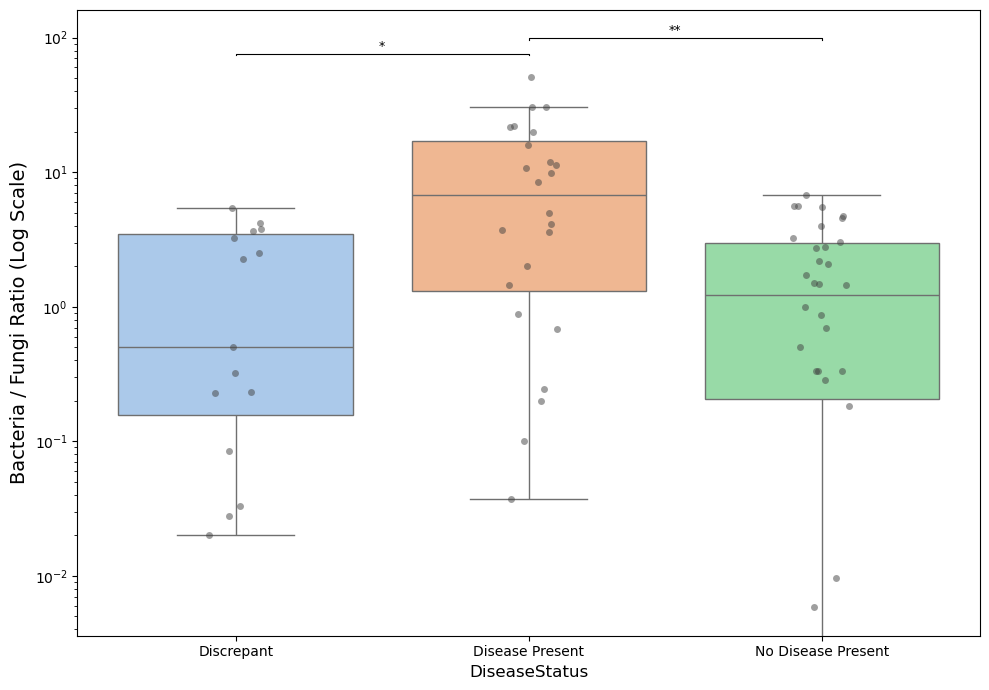


Script finished.


In [52]:
def prepare_relative_abundances_and_metadata( 
        otu_table_csv_path, 
        metadata_csv_path,
        metadata_sample_id_col="#SampleID", 
        metadata_grouping_col="DiseaseStatus", 
        otu_domain_col="Domain"
    ):
    """
    Reads an OTU table and metadata, calculates domain relative abundance.
    Returns the relative_abundances DataFrame, df_sample_order, and metadata_grouping_col name.
    In case of error or inability to process, returns None, None, None.
    """
    try:
        df_otu = pd.read_csv(otu_table_csv_path)
        print(f"Successfully loaded OTU table: '{otu_table_csv_path}' (Shape: {df_otu.shape})")
    except FileNotFoundError:
        print(f"Error: OTU table file '{otu_table_csv_path}' not found.")
        return None, None, None 
    except Exception as e:
        print(f"Error loading OTU table CSV: {e}")
        return None, None, None 

    try:
        df_metadata = pd.read_csv(metadata_csv_path)
        print(f"Successfully loaded metadata: '{metadata_csv_path}' (Shape: {df_metadata.shape})")
    except FileNotFoundError:
        print(f"Error: Metadata file '{metadata_csv_path}' not found.")
        return None, None, None 
    except Exception as e:
        print(f"Error loading metadata CSV: {e}")
        return None, None, None 

    if df_otu.empty or df_metadata.empty:
        print("One or both DataFrames are empty. Cannot proceed.")
        return None, None, None 

    if metadata_sample_id_col not in df_metadata.columns:
        print(f"Error: Metadata Sample ID column '{metadata_sample_id_col}' not found in metadata file.")
        return None, None, None 
    if metadata_grouping_col not in df_metadata.columns:
        print(f"Error: Metadata grouping column '{metadata_grouping_col}' not found in metadata file.")
        return None, None, None 
    
    df_metadata[metadata_sample_id_col] = df_metadata[metadata_sample_id_col].astype(str)
    df_metadata[metadata_grouping_col] = df_metadata[metadata_grouping_col].fillna('UnknownStatus').astype(str)

    sample_column_pattern = re.compile(r'^[A-Z]\d{2}$')
    sample_columns_otu = [col for col in df_otu.columns if sample_column_pattern.match(col)]

    if not sample_columns_otu:
        print(f"Error: No sample columns matching pattern '[A-Z]\\d{{2}}' found in OTU table.")
        return None, None, None 
    print(f"Identified OTU sample columns: {len(sample_columns_otu)}")

    if otu_domain_col not in df_otu.columns:
        print(f"Error: OTU domain column '{otu_domain_col}' not found in OTU table.")
        return None, None, None 
    
    for col in sample_columns_otu:
        df_otu[col] = pd.to_numeric(df_otu[col], errors='coerce')
    df_otu[sample_columns_otu] = df_otu[sample_columns_otu].fillna(0)

    df_otu['Processed_Domain'] = df_otu[otu_domain_col].apply(extract_domain_from_taxonomy_string)
    print(f"Unique processed domains from OTU table: {df_otu['Processed_Domain'].nunique()}")

    domain_abundances_abs = df_otu.groupby('Processed_Domain')[sample_columns_otu].sum()

    group_mapping = pd.Series(df_metadata[metadata_grouping_col].values, index=df_metadata[metadata_sample_id_col]).to_dict()
    samples_to_plot_info = []
    for sample_id in domain_abundances_abs.columns:
        if sample_id in group_mapping:
            samples_to_plot_info.append({'SampleID': sample_id, 'Group': group_mapping[sample_id]})
        else:
            print(f"Warning: SampleID '{sample_id}' from OTU table not found in metadata. It will be excluded from B/F ratio analysis.")
    
    if not samples_to_plot_info:
        print("Error: No samples from OTU table found in metadata. Cannot proceed with B/F ratio analysis.")
        return None, None, None 
        
    df_sample_order = pd.DataFrame(samples_to_plot_info)
    df_sample_order.sort_values(by=['Group', 'SampleID'], inplace=True) 
    
    sorted_sample_ids = df_sample_order['SampleID'].tolist()
    
    domain_abundances_abs_sorted = domain_abundances_abs[sorted_sample_ids]
    
    sample_totals = domain_abundances_abs_sorted.sum(axis=0)
    sample_totals[sample_totals == 0] = 1 
    relative_abundances = domain_abundances_abs_sorted.div(sample_totals, axis=1) * 100

    if relative_abundances.empty:
        print("No relative abundance data after processing. Check inputs.")
        return None, None, None

    print("Data processing for relative abundances complete.")
    return relative_abundances, df_sample_order, metadata_grouping_col


def plot_bacteria_fungi_ratio_boxplot( 
        relative_abundances_df, 
        sample_order_df, 
        grouping_col_name,
        output_plot_path="bacteria_fungi_ratio_boxplot.png", 
        pseudocount=1e-9 
    ):
    """
    Calculates Bacteria/Fungi ratio, removes outliers per group, performs statistical tests, 
    and plots as boxplots grouped by the specified metadata column, with a log-scaled y-axis.
    Boxplot outliers (fliers) are not shown by boxplot itself.
    """
    if relative_abundances_df is None or relative_abundances_df.empty:
        print("Cannot plot B/F ratio: Relative abundances data is missing or empty.")
        return
    if sample_order_df is None or sample_order_df.empty:
        print("Cannot plot B/F ratio: Sample order/metadata information is missing or empty.")
        return

    print("\nCalculating Bacteria/Fungi ratios...")
    
    fungi_label = "Fungi" 
    bacteria_label = "Bacteria" 

    if fungi_label not in relative_abundances_df.index:
        print(f"Warning: Domain '{fungi_label}' not found in relative abundances. Fungi abundance will be treated as 0 (+ pseudocount) for B/F ratio.")
        fungi_abundances = pd.Series(0, index=relative_abundances_df.columns) 
    else:
        fungi_abundances = relative_abundances_df.loc[fungi_label]

    if bacteria_label not in relative_abundances_df.index:
        print(f"Warning: Domain '{bacteria_label}' not found in relative abundances. Bacteria abundance will be treated as 0 for B/F ratio.")
        bacteria_abundances = pd.Series(0, index=relative_abundances_df.columns) 
    else:
        bacteria_abundances = relative_abundances_df.loc[bacteria_label]

    bf_ratios = bacteria_abundances / (fungi_abundances + pseudocount) 
    
    bf_ratios_df = bf_ratios.reset_index()
    bf_ratios_df.columns = ['SampleID', 'Bacteria_Fungi_Ratio'] 

    plot_data_full = pd.merge(bf_ratios_df, sample_order_df[['SampleID', 'Group']], on='SampleID')
    plot_data_full.rename(columns={'Group': grouping_col_name}, inplace=True) 

    if plot_data_full.empty:
        print("No data available for B/F ratio boxplot after merging. Check sample IDs and data.")
        return

    print(f"Data prepared before outlier removal (first 5 rows):\n{plot_data_full.head()}")

    # Outlier Removal per group
    print("\nIdentifying and removing outliers (based on 1.5*IQR) per group...")
    plot_data_no_outliers_list = []
    for group_name, group_data in plot_data_full.groupby(grouping_col_name):
        q1 = group_data['Bacteria_Fungi_Ratio'].quantile(0.25)
        q3 = group_data['Bacteria_Fungi_Ratio'].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        outliers = group_data[(group_data['Bacteria_Fungi_Ratio'] < lower_bound) | (group_data['Bacteria_Fungi_Ratio'] > upper_bound)]
        if not outliers.empty:
            print(f"  Outliers removed from group '{group_name}':")
            for idx, row in outliers.iterrows():
                print(f"    SampleID: {row['SampleID']}, Ratio: {row['Bacteria_Fungi_Ratio']:.2e}")
        
        non_outliers = group_data[(group_data['Bacteria_Fungi_Ratio'] >= lower_bound) & (group_data['Bacteria_Fungi_Ratio'] <= upper_bound)]
        plot_data_no_outliers_list.append(non_outliers)
    
    if not plot_data_no_outliers_list:
        print("No data remaining after attempting outlier removal. Cannot plot.")
        return
        
    plot_data_filtered = pd.concat(plot_data_no_outliers_list)
    
    if plot_data_filtered.empty:
        print("No data remaining after outlier removal across all groups. Cannot plot.")
        return
    print(f"\nData after outlier removal (first 5 rows):\n{plot_data_filtered.head()}")
    #END OF OUTLIER REMOVAL


    fig, ax = plt.subplots(figsize=(10, 7)) 
    plt.style.use('seaborn-v0_8-pastel')
    
    # Use filtered data for plotting
    sns.boxplot(x=grouping_col_name, y='Bacteria_Fungi_Ratio', data=plot_data_filtered, palette="pastel", ax=ax, showfliers=False, hue=grouping_col_name, legend=False)
    sns.stripplot(x=grouping_col_name, y='Bacteria_Fungi_Ratio', data=plot_data_filtered, color=".25", alpha=0.5, jitter=True, ax=ax)

    ax.set_yscale('log') 
    # ax.set_title(f'Bacteria/Fungi Ratio by {grouping_col_name} (Log Scale, Outliers Removed)', fontsize=16)
    ax.set_xlabel(grouping_col_name, fontsize=12)
    ax.set_ylabel('Bacteria / Fungi Ratio (Log Scale)', fontsize=14)
    
    # plt.xticks(rotation=0, ha='center', fontsize=10)
    # ax.grid(True, which="both", ls="--", linewidth=0.5, axis='y')
    
    # Statistical Analysis (using filtered data)
    groups = plot_data_filtered[grouping_col_name].unique() # Use unique groups from filtered data
    group_order_on_plot = sorted(groups) 
    if isinstance(plot_data_filtered[grouping_col_name].dtype, pd.CategoricalDtype):
        group_order_on_plot = plot_data_filtered[grouping_col_name].cat.categories.tolist()


    print("\n--- Statistical Analysis (Mann-Whitney U test with Bonferroni Correction on data with outliers removed) ---")
    if len(group_order_on_plot) >= 2:
        comparisons = list(combinations(group_order_on_plot, 2))
        raw_p_values = []
        comparison_pairs = []

        for group1, group2 in comparisons:
            # Use filtered data for stats
            data1 = plot_data_filtered[plot_data_filtered[grouping_col_name] == group1]['Bacteria_Fungi_Ratio'].dropna()
            data2 = plot_data_filtered[plot_data_filtered[grouping_col_name] == group2]['Bacteria_Fungi_Ratio'].dropna()
            
            if len(data1) < 1 or len(data2) < 1: 
                print(f"Skipping comparison between {group1} and {group2}: not enough data after outlier removal.")
                continue 

            try:
                stat, p_value = mannwhitneyu(data1, data2, alternative='two-sided')
                raw_p_values.append(p_value)
                comparison_pairs.append((group1, group2))
            except ValueError as e:
                print(f"Could not perform Mann-Whitney U for {group1} vs {group2}: {e}. Assigning p=1.")
                raw_p_values.append(1.0)
                comparison_pairs.append((group1, group2))


        if raw_p_values: 
            reject, corrected_p_values, _, _ = multipletests(raw_p_values, alpha=0.05, method='bonferroni')
            
            print("\nPairwise Comparison Results (after outlier removal):")
            print(f"{'Comparison':<30} | {'Raw P-Value':<15} | {'Bonferroni P-Value':<20} | {'Significant (alpha=0.05)':<15}")
            print("-" * 85)
            
            # Plot Annotations
            # Annotation positioning might need adjustment based on the new y-axis scale after outlier removal
            all_y_values_filtered = plot_data_filtered['Bacteria_Fungi_Ratio'].dropna()
            y_max_filtered_data = all_y_values_filtered[all_y_values_filtered > 0].max() if not all_y_values_filtered[all_y_values_filtered > 0].empty else 1.0
            
            annotation_y_start = y_max_filtered_data * 1.5 
            # Make sure annotation_y_start is not excessively high if y_max_filtered_data is tiny
            if y_max_filtered_data < 1 and annotation_y_start < 10: annotation_y_start = max(annotation_y_start, y_max_filtered_data * 5)
            if annotation_y_start <=0 : annotation_y_start = 1.0 # Fallback for log scale

            y_step_factor = 1.3 
            current_annotation_y = annotation_y_start

            for i, (group1, group2) in enumerate(comparison_pairs):
                if i >= len(corrected_p_values): continue 

                significant = reject[i]
                corrected_p = corrected_p_values[i]
                
                print(f"{group1} vs {group2:<21} | {raw_p_values[i]:<15.4g} | {corrected_p:<20.4g} | {significant:<15}")

                if significant: 
                    try:
                        x1 = group_order_on_plot.index(group1)
                        x2 = group_order_on_plot.index(group2)
                    except ValueError:
                        print(f"Warning: Group {group1} or {group2} not found in plot order for annotation. Skipping annotation.")
                        continue

                    max_val_g1 = plot_data_filtered[plot_data_filtered[grouping_col_name] == group1]['Bacteria_Fungi_Ratio'].max()
                    max_val_g2 = plot_data_filtered[plot_data_filtered[grouping_col_name] == group2]['Bacteria_Fungi_Ratio'].max()
                    line_y_base = max(max_val_g1 if pd.notna(max_val_g1) else 0, 
                                      max_val_g2 if pd.notna(max_val_g2) else 0)
                    
                    target_y_for_this_annotation = line_y_base * 1.2 
                    current_annotation_y = max(current_annotation_y, target_y_for_this_annotation)


                    line_kwargs = {'color': 'black', 'linewidth': 0.8}
                    ax.plot([x1, x1, x2, x2], [current_annotation_y * 0.98, current_annotation_y, current_annotation_y, current_annotation_y * 0.98], **line_kwargs)
                    
                    p_text = f"p={corrected_p:.2g}" 
                    if corrected_p < 0.001: p_text = "***"
                    elif corrected_p < 0.01: p_text = "**"
                    elif corrected_p < 0.05: p_text = "*"
                    
                    ax.text((x1 + x2) / 2, current_annotation_y * 1.02, p_text, ha='center', va='bottom', fontsize=9)
                    
                    current_annotation_y *= y_step_factor 
            print("-" * 85)
        else:
            print("No pairwise comparisons were performed (e.g., less than 2 groups or no data for comparisons after outlier removal).")
    else:
        print("Less than 2 groups found. No pairwise statistical tests will be performed.")
    
    plt.tight_layout()

    try:
        plt.savefig(output_plot_path, bbox_inches='tight', dpi=300)
        print(f"Bacteria/Fungi ratio boxplot saved to '{output_plot_path}'") 
        plt.show()
    except Exception as e:
        print(f"Error saving B/F ratio boxplot: {e}")


if __name__ == "__main__":
    otu_file = "otu_table_uclust_with_updated_taxonomy_05172025_78bats_singletsRemoved_78bats_filtered_domains_combined_by_genus_keep_blanks_species_column_removed.csv"
    meta_file = "otu_metadata_uclust_updated_taxonomy_05162025.csv"
    
    metadata_sample_col = "SampleID" 
    metadata_group_col = "DiseaseStatus" 
    otu_taxonomy_col = "Domain" 

    bf_ratio_boxplot_file = "bacteria_fungi_ratio_by_disease_status_no_outliers_stats.png" # Updated filename
    
    if not os.path.exists(otu_file):
        print(f"CRITICAL ERROR: The OTU table file '{otu_file}' was not found.")
    elif not os.path.exists(meta_file):
        print(f"CRITICAL ERROR: The metadata file '{meta_file}' was not found.")
    else:
        print(f"--- Processing OTU Table and Metadata for B/F Ratios ---") 
        print(f"Processing OTU table: {otu_file}")
        print(f"Using metadata: {meta_file}")
        
        rel_abundances, sample_info_for_plot, actual_grouping_col_name = prepare_relative_abundances_and_metadata(
            otu_table_csv_path=otu_file,
            metadata_csv_path=meta_file,
            metadata_sample_id_col=metadata_sample_col,
            metadata_grouping_col=metadata_group_col, 
            otu_domain_col=otu_taxonomy_col
        )
        
        print("\n--- Generating Boxplot of Bacteria/Fungi Ratio (Log Scale, Outliers Removed) with Stats ---") 
        if rel_abundances is not None and sample_info_for_plot is not None and actual_grouping_col_name is not None:
            plot_bacteria_fungi_ratio_boxplot( 
                relative_abundances_df=rel_abundances,
                sample_order_df=sample_info_for_plot, 
                grouping_col_name=actual_grouping_col_name,
                output_plot_path=bf_ratio_boxplot_file 
            )
        else:
            print("Skipping B/F ratio boxplot due to issues in data processing step or missing returned values.")
            
        print("\nScript finished.")
 

## Plot with Season Grouping

--- Processing OTU Table and Metadata for B/F Ratios ---
Successfully loaded OTU table: 'otu_table_uclust_with_updated_taxonomy_05172025_78bats_singletsRemoved_78bats_filtered_domains_combined_by_genus_keep_blanks_species_column_removed.csv' (Shape: (617, 88))
Successfully loaded metadata: 'otu_metadata_uclust_updated_taxonomy_05162025.csv' (Shape: (78, 26))
Identified 78 OTU sample columns: ['A01', 'A02', 'A03', 'A04', 'A05', 'A08', 'A09', 'A10', 'A12', 'B01']...
Unique processed domains from OTU table: ['Fungi' 'Unknown' 'Bacteria']
Data processing for relative abundances complete.

--- Generating Point Plot of Bacteria/Fungi Ratio (Faceted by DiseaseStatus, Colored by DiseaseStatus) ---

Calculating Bacteria/Fungi ratios...
Data prepared for plotting (first 5 rows):
  SampleID  Bacteria_Fungi_Ratio DiseaseStatus_Group Season
0      A04              0.500000          Discrepant   Fall
1      B09              0.027778          Discrepant   Fall
2      D05              0.230769        

C:\Users\derek\AppData\Local\Temp\ipykernel_9628\1703901885.py:219: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  g = sns.catplot(
C:\Users\derek\AppData\Local\Temp\ipykernel_9628\1703901885.py:219: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  g = sns.catplot(



--- Stats: DiseaseStatus vs DiseaseStatus (pooled seasons, on filtered data) ---
  Comparison                     | Raw P      | Corrected P     | Significant Text
  Discrepant vs Disease Present       | 0.0184     | 0.0552          | p=0.055
  Discrepant vs No Disease Present    | 0.293      | 0.879           | p=0.88
  Disease Present vs No Disease Present    | 0.000276   | 0.000829        | ***

--- Stats: Season vs Season (within each DiseaseStatus facet, on filtered data) ---

  Disease Status Group (Facet): Discrepant
    Comparison           | Raw P      | Corrected P     | Significant Text
    Fall vs Winter        | 0.00606    | 0.0182          | *
    Fall vs Spring        | 0.0221     | 0.0664          | p=0.066
    Winter vs Spring        | 0.114      | 0.343           | p=0.34

  Disease Status Group (Facet): Disease Present
    Comparison           | Raw P      | Corrected P     | Significant Text
    Fall vs Winter        | 0.616      | 1               | p=1
    Fall vs

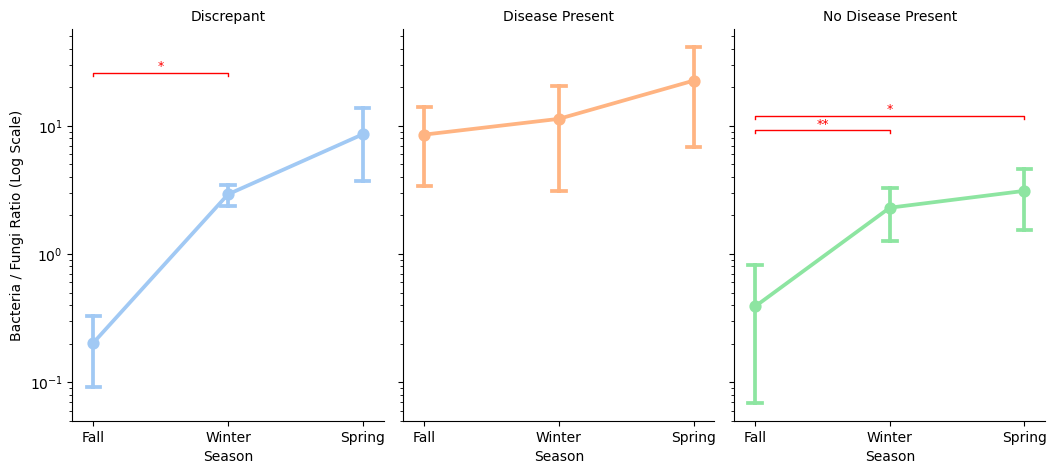


Script finished.


In [90]:
def extract_domain_from_taxonomy_string(taxonomy_string):
    """
    Extracts domain (e.g., Bacteria, Fungi) from a taxonomy string.
    Assumes the input 'taxonomy_string' is the content of the 'Domain' column from OTU table.
    """
    if pd.isna(taxonomy_string):
        return "Unknown"
    
    # If the string itself is a direct domain name
    if taxonomy_string in ["Bacteria", "Fungi", "Archaea"]:
        return taxonomy_string

    # Attempt to parse typical taxonomy strings like "k__Bacteria;p__..."
    parts = str(taxonomy_string).split(';')
    for part in parts:
        # Check for kingdom level (k__) or domain level (d__)
        if part.startswith('k__') or part.startswith('d__'):
            domain_candidate = part[3:]
            if domain_candidate in ["Bacteria", "Fungi", "Archaea"]:
                return domain_candidate
            # Simple keyword check if formatted names are not present
            if "bacter" in domain_candidate.lower(): return "Bacteria"
            if "fung" in domain_candidate.lower(): return "Fungi"
            if "archae" in domain_candidate.lower(): return "Archaea"
            
    # Fallback keyword search in the whole string
    if "bacteria" in str(taxonomy_string).lower(): return "Bacteria"
    if "fungi" in str(taxonomy_string).lower(): return "Fungi"
    if "archaea" in str(taxonomy_string).lower(): return "Archaea"
    
    return "Unknown"


def prepare_relative_abundances_and_metadata(
        otu_table_csv_path,
        metadata_csv_path,
        metadata_sample_id_col="SampleID",
        metadata_disease_status_col="DiseaseStatus",
        metadata_season_col="Season",
        otu_domain_col="Domain" 
    ):
    try:
        df_otu = pd.read_csv(otu_table_csv_path)
        print(f"Successfully loaded OTU table: '{otu_table_csv_path}' (Shape: {df_otu.shape})")
    except FileNotFoundError:
        print(f"Error: OTU table file '{otu_table_csv_path}' not found.")
        return None, None, None, None
    except Exception as e:
        print(f"Error loading OTU table CSV: {e}")
        return None, None, None, None

    try:
        df_metadata = pd.read_csv(metadata_csv_path)
        print(f"Successfully loaded metadata: '{metadata_csv_path}' (Shape: {df_metadata.shape})")
    except FileNotFoundError:
        print(f"Error: Metadata file '{metadata_csv_path}' not found.")
        return None, None, None, None
    except Exception as e:
        print(f"Error loading metadata CSV: {e}")
        return None, None, None, None

    if df_otu.empty or df_metadata.empty:
        print("One or both DataFrames are empty. Cannot proceed.")
        return None, None, None, None

    required_meta_cols = [metadata_sample_id_col, metadata_disease_status_col, metadata_season_col]
    if not all(col in df_metadata.columns for col in required_meta_cols):
        print(f"Error: One or more required metadata columns ({', '.join(required_meta_cols)}) not found in metadata. Available: {df_metadata.columns.tolist()}")
        return None, None, None, None
    
    df_metadata[metadata_sample_id_col] = df_metadata[metadata_sample_id_col].astype(str)
    df_metadata[metadata_disease_status_col] = df_metadata[metadata_disease_status_col].fillna('UnknownStatus').astype(str)
    df_metadata[metadata_season_col] = df_metadata[metadata_season_col].fillna('UnknownSeason').astype(str)

    metadata_sample_ids_as_strings = df_metadata[metadata_sample_id_col].astype(str).unique()
    sample_columns_otu = [col for col in df_otu.columns if col in metadata_sample_ids_as_strings]

    if not sample_columns_otu:
        print("No direct match for sample IDs in OTU table columns. Trying regex pattern...")
        sample_column_pattern = re.compile(r'^[A-Z]\d{2}(\S*)?$') 
        sample_columns_otu_regex = [col for col in df_otu.columns if sample_column_pattern.match(col)]
        if sample_columns_otu_regex:
             sample_columns_otu = sample_columns_otu_regex
        else:
            print(f"Error: No sample columns identified in OTU table. Checked direct match with metadata SampleIDs and regex. OTU columns (first 20): {df_otu.columns.tolist()[:20]}")
            return None, None, None, None
            
    print(f"Identified {len(sample_columns_otu)} OTU sample columns: {sample_columns_otu[:10]}...")

    if otu_domain_col not in df_otu.columns:
        print(f"Error: OTU domain column '{otu_domain_col}' not found in OTU table. Available: {df_otu.columns.tolist()}")
        return None, None, None, None
    
    for col in sample_columns_otu:
        if col in df_otu.columns:
             df_otu[col] = pd.to_numeric(df_otu[col], errors='coerce')
        else:
            print(f"Warning: Identified sample column '{col}' not in OTU DataFrame during numeric conversion.")
    df_otu = df_otu.fillna({col: 0 for col in sample_columns_otu if col in df_otu.columns})

    df_otu['Processed_Domain'] = df_otu[otu_domain_col].apply(extract_domain_from_taxonomy_string)
    print(f"Unique processed domains from OTU table: {df_otu['Processed_Domain'].unique()}")

    domain_abundances_abs = df_otu.groupby('Processed_Domain')[sample_columns_otu].sum()
    
    df_metadata[metadata_sample_id_col] = df_metadata[metadata_sample_id_col].astype(str)
    metadata_relevant_samples = df_metadata[df_metadata[metadata_sample_id_col].isin(sample_columns_otu)]
    
    if metadata_relevant_samples.empty:
        print("Error: No samples in metadata match the sample columns identified in the OTU table.")
        return None, None, None, None

    df_sample_info = metadata_relevant_samples[[metadata_sample_id_col, metadata_disease_status_col, metadata_season_col]].copy()
    df_sample_info.rename(columns={
        metadata_sample_id_col: 'SampleID',
        metadata_disease_status_col: 'DiseaseStatus_Group' 
    }, inplace=True)

    df_sample_info.sort_values(by=['DiseaseStatus_Group', metadata_season_col, 'SampleID'], inplace=True)
    
    sorted_sample_ids = df_sample_info['SampleID'].tolist()
    
    valid_otu_cols_for_abundance = [s_id for s_id in sorted_sample_ids if s_id in domain_abundances_abs.columns]
    missing_in_otu_cols = [s_id for s_id in sorted_sample_ids if s_id not in domain_abundances_abs.columns]
    if missing_in_otu_cols:
        print(f"Warning: {len(missing_in_otu_cols)} SampleIDs from metadata/sorting are not columns in the OTU abundance data. Examples: {missing_in_otu_cols[:5]}")
        df_sample_info = df_sample_info[df_sample_info['SampleID'].isin(valid_otu_cols_for_abundance)].copy()
        sorted_sample_ids = valid_otu_cols_for_abundance

    if not sorted_sample_ids:
         print("Error: No valid sorted sample IDs remain after checking against OTU data columns.")
         return None, None, None, None

    domain_abundances_abs_sorted = domain_abundances_abs[sorted_sample_ids]
    
    sample_totals = domain_abundances_abs_sorted.sum(axis=0)
    sample_totals[sample_totals == 0] = 1 
    relative_abundances = domain_abundances_abs_sorted.div(sample_totals, axis=1) * 100

    if relative_abundances.empty:
        print("No relative abundance data after processing. Check inputs.")
        return None, None, None, None

    print("Data processing for relative abundances complete.")
    return relative_abundances, df_sample_info, 'DiseaseStatus_Group', metadata_season_col


def plot_bacteria_fungi_ratio_pointplot(
        relative_abundances_df,
        sample_info_df, 
        disease_status_col, 
        season_col,         
        output_plot_path="bacteria_fungi_ratio_pointplot.png", 
        pseudocount=1e-9
    ):
    if relative_abundances_df is None or relative_abundances_df.empty:
        print("Cannot plot B/F ratio: Relative abundances data is missing or empty.")
        return
    if sample_info_df is None or sample_info_df.empty:
        print("Cannot plot B/F ratio: Sample info data is missing or empty.")
        return

    print("\nCalculating Bacteria/Fungi ratios...")
    fungi_label, bacteria_label = "Fungi", "Bacteria"

    fungi_abundances = relative_abundances_df.loc[fungi_label] if fungi_label in relative_abundances_df.index else pd.Series(0, index=relative_abundances_df.columns)
    bacteria_abundances = relative_abundances_df.loc[bacteria_label] if bacteria_label in relative_abundances_df.index else pd.Series(0, index=relative_abundances_df.columns)
    
    if fungi_label not in relative_abundances_df.index: print(f"Warning: Domain '{fungi_label}' not found. Using 0 + pseudocount.")
    if bacteria_label not in relative_abundances_df.index: print(f"Warning: Domain '{bacteria_label}' not found. Using 0.")

    bf_ratios = bacteria_abundances / (fungi_abundances + pseudocount)
    bf_ratios_df = bf_ratios.reset_index()
    bf_ratios_df.columns = ['SampleID', 'Bacteria_Fungi_Ratio']

    plot_data_full = pd.merge(bf_ratios_df, sample_info_df, on='SampleID')

    if plot_data_full.empty:
        print("No data available for B/F ratio plot after merging. Check sample IDs and data.")
        return
    print(f"Data prepared for plotting (first 5 rows):\n{plot_data_full.head()}")

    print("\nIdentifying and removing outliers (based on 1.5*IQR) per [Disease Status, Season] group...")
    plot_data_no_outliers_list = []
    for group_keys, group_data in plot_data_full.groupby([disease_status_col, season_col]):
        q1 = group_data['Bacteria_Fungi_Ratio'].quantile(0.25)
        q3 = group_data['Bacteria_Fungi_Ratio'].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        non_outliers = group_data[(group_data['Bacteria_Fungi_Ratio'] >= lower_bound) & (group_data['Bacteria_Fungi_Ratio'] <= upper_bound)]
        plot_data_no_outliers_list.append(non_outliers)
        
        outliers = group_data[(group_data['Bacteria_Fungi_Ratio'] < lower_bound) | (group_data['Bacteria_Fungi_Ratio'] > upper_bound)]
        if not outliers.empty:
            print(f"  Outliers removed from group '{group_keys}': {len(outliers)} sample(s)")

    if not plot_data_no_outliers_list:
        print("No data groups remaining after attempting outlier removal (list is empty). Cannot plot.")
        return
        
    plot_data_filtered = pd.concat(plot_data_no_outliers_list)
    
    if plot_data_filtered.empty:
        print("No data remaining after outlier removal across all groups. Cannot plot.")
        return
    print(f"\nData after outlier removal (first 5 rows):\n{plot_data_filtered.head()}")

    disease_group_order = sorted(plot_data_filtered[disease_status_col].unique())
    season_order_defined = ['Fall', 'Winter', 'Spring'] 
    actual_season_order_in_data = [s for s in season_order_defined if s in plot_data_filtered[season_col].unique()]
    if not actual_season_order_in_data:
        actual_season_order_in_data = sorted(plot_data_filtered[season_col].unique())


    plt.style.use('seaborn-v0_8-pastel') # Apply Seaborn style

    g = sns.catplot(
        x=season_col, 
        y='Bacteria_Fungi_Ratio',
        col=disease_status_col, 
        hue=disease_status_col, # Color lines by DiseaseStatus
        data=plot_data_filtered,
        kind="point",
        order=actual_season_order_in_data, 
        col_order=disease_group_order,    
        hue_order=disease_group_order, # Match hue order with col_order
        palette="pastel", # Apply pastel palette to hue
        capsize=.1,
        ci=95, 
        estimator=np.mean,
        height=5, 
        aspect=0.7, 
        sharey=True, 
        join=True, # Connect points for seasons within each facet by DiseaseStatus line type
        legend=False # No Show legend for hue (DiseaseStatus)
    )

    g.set(yscale='log')
    g.set_axis_labels(x_var=season_col.replace("_", " "), y_var='Bacteria / Fungi Ratio (Log Scale)')
    g.set_titles(col_template="{col_name}") 
    g.fig.subplots_adjust(top=0.9) 
    # g.fig.suptitle('Bacteria/Fungi Ratio by Season and Disease Status', fontsize=16, y=0.98)
    


    # Statistical Analysis
    annotation_y_values_used_on_facets = {} 
    
    def get_p_text(p_corrected):
        if p_corrected < 0.001: return "***"
        if p_corrected < 0.01: return "**"
        if p_corrected < 0.05: return "*"
        return f"p={p_corrected:.2g}" 
    
    def draw_sig_bar_on_facet(ax_plot, x1_idx, x2_idx, y_pos, p_val_text, h_factor=0.05, color='k', text_size=9):
        h_val = y_pos * h_factor 
        ax_plot.plot([x1_idx, x1_idx, x2_idx, x2_idx], [y_pos, y_pos + h_val, y_pos + h_val, y_pos], lw=1.0, c=color)
        ax_plot.text((x1_idx + x2_idx) / 2, y_pos + h_val * 1.1, p_val_text, ha='center', va='bottom', color=color, fontsize=text_size)
        
        current_max_y = annotation_y_values_used_on_facets.get(ax_plot, 0) # Initialize with 0 if not present
        annotation_y_values_used_on_facets[ax_plot] = max(current_max_y, y_pos + h_val * 1.1 + h_val * 0.5)

    print("\n--- Stats: DiseaseStatus vs DiseaseStatus (pooled seasons, on filtered data) ---")
    if len(disease_group_order) >= 2:
        ds_comparisons = list(combinations(disease_group_order, 2))
        ds_p_values_raw, valid_ds_comparisons = [], []
        for ds1, ds2 in ds_comparisons:
            data1 = plot_data_filtered[plot_data_filtered[disease_status_col] == ds1]['Bacteria_Fungi_Ratio'].dropna()
            data2 = plot_data_filtered[plot_data_filtered[disease_status_col] == ds2]['Bacteria_Fungi_Ratio'].dropna()
            if len(data1) >=3 and len(data2) >=3 : 
                stat, p = mannwhitneyu(data1, data2, alternative='two-sided')
                ds_p_values_raw.append(p); valid_ds_comparisons.append((ds1, ds2))
            else:
                ds_p_values_raw.append(1.0); valid_ds_comparisons.append((ds1, ds2)) 

        if ds_p_values_raw:
            ds_reject_overall, ds_p_values_corrected_overall, _, _ = multipletests(ds_p_values_raw, alpha=0.05, method='bonferroni')
            print(f"  {'Comparison':<30} | {'Raw P':<10} | {'Corrected P':<15} | Significant Text")
            for i, (ds1, ds2) in enumerate(valid_ds_comparisons):
                p_text_ds = get_p_text(ds_p_values_corrected_overall[i])
                print(f"  {ds1} vs {ds2:<21} | {ds_p_values_raw[i]:<10.3g} | {ds_p_values_corrected_overall[i]:<15.3g} | {p_text_ds}")
    
    print("\n--- Stats: Season vs Season (within each DiseaseStatus facet, on filtered data) ---")
    y_pos_season_comp_start_factor = 1.3 
    
    for i_col, ds_group in enumerate(disease_group_order):
        ax_facet = g.axes[0, i_col] if len(g.axes.shape) > 1 and g.axes.ndim == 2 else g.axes[i_col] 
        annotation_y_values_used_on_facets[ax_facet] = ax_facet.get_ylim()[0] # Use bottom of y-axis as initial floor

        print(f"\n  Disease Status Group (Facet): {ds_group}")
        data_ds_group = plot_data_filtered[plot_data_filtered[disease_status_col] == ds_group]
        
        season_comparisons_local = list(combinations(actual_season_order_in_data, 2))
        s_p_values_raw_local, valid_s_comparisons_local = [], []

        for s1, s2 in season_comparisons_local:
            data1 = data_ds_group[data_ds_group[season_col] == s1]['Bacteria_Fungi_Ratio'].dropna()
            data2 = data_ds_group[data_ds_group[season_col] == s2]['Bacteria_Fungi_Ratio'].dropna()
            if len(data1) >=3 and len(data2) >=3:
                stat, p = mannwhitneyu(data1, data2, alternative='two-sided')
                s_p_values_raw_local.append(p); valid_s_comparisons_local.append((s1, s2))
            else:
                s_p_values_raw_local.append(1.0); valid_s_comparisons_local.append((s1,s2))

        if not s_p_values_raw_local: continue
        
        reject_local, s_p_values_corrected_local, _, _ = multipletests(s_p_values_raw_local, alpha=0.05, method='bonferroni')
        
        # Determine max y for annotation start on this specific facet more robustly
        max_y_in_this_facet_for_anno = 0
        # Get y-values of points and CIs plotted on this facet
        ####  Note: this is complex to extract directly from catplot's internals for pointplot means/CIs
        #### Fallback: use max of filtered data in this group
        if not data_ds_group.empty:
            max_val_data = data_ds_group['Bacteria_Fungi_Ratio'].max()
            if pd.notna(max_val_data) and max_val_data > 0:
                max_y_in_this_facet_for_anno = max_val_data
        if max_y_in_this_facet_for_anno <=0 : max_y_in_this_facet_for_anno = ax_facet.get_ylim()[0] * 1.1 # Small value above bottom for log
        if max_y_in_this_facet_for_anno == 0 or pd.isna(max_y_in_this_facet_for_anno) : max_y_in_this_facet_for_anno = 1.0 # if all means are 0 or data empty

        y_pos_season_current = max_y_in_this_facet_for_anno * y_pos_season_comp_start_factor

        print(f"    {'Comparison':<20} | {'Raw P':<10} | {'Corrected P':<15} | Significant Text")
        for i_s_comp, (s1, s2) in enumerate(valid_s_comparisons_local):
            p_text_s = get_p_text(s_p_values_corrected_local[i_s_comp])
            print(f"    {s1} vs {s2:<13} | {s_p_values_raw_local[i_s_comp]:<10.3g} | {s_p_values_corrected_local[i_s_comp]:<15.3g} | {p_text_s}")

            if p_text_s not in [f"p={s_p_values_corrected_local[i_s_comp]:.2g}", ""]: 
                x1_facet_idx = actual_season_order_in_data.index(s1)
                x2_facet_idx = actual_season_order_in_data.index(s2)
                
                draw_sig_bar_on_facet(ax_facet, x1_facet_idx, x2_facet_idx, y_pos_season_current, p_text_s, color='red', h_factor=0.05)
                y_pos_season_current *= 1.3 
    
    for ax_f, max_y_anno in annotation_y_values_used_on_facets.items():
        if max_y_anno > ax_f.get_ylim()[0] : # Check if any annotations were made and sensible
            current_ylim_f = ax_f.get_ylim()
            new_upper_lim = max(current_ylim_f[1], max_y_anno * 1.1) 
            ax_f.set_ylim(current_ylim_f[0], new_upper_lim)

    try:
        g.fig.savefig(output_plot_path, dpi=300, bbox_inches='tight') 
        print(f"\nBacteria/Fungi ratio point plot saved to '{output_plot_path}'")
        plt.show()
    except Exception as e:
        print(f"Error saving B/F ratio plot: {e}")


if __name__ == "__main__":
    otu_file = "otu_table_uclust_with_updated_taxonomy_05172025_78bats_singletsRemoved_78bats_filtered_domains_combined_by_genus_keep_blanks_species_column_removed.csv"
    meta_file = "otu_metadata_uclust_updated_taxonomy_05162025.csv"
    
    metadata_sample_col = "SampleID" 
    metadata_disease_status_col_param = "DiseaseStatus" 
    metadata_season_col_param = "Season" 
    otu_taxonomy_col_param = "Domain"

    bf_ratio_pointplot_file = "bf_ratio_disease_season_catplot_point_coloredDS.png" # New filename
    
    if not os.path.exists(otu_file):
        print(f"CRITICAL ERROR: The OTU table file '{otu_file}' was not found.")
    elif not os.path.exists(meta_file):
        print(f"CRITICAL ERROR: The metadata file '{meta_file}' was not found.")
    else:
        print(f"--- Processing OTU Table and Metadata for B/F Ratios ---")
        
        rel_abundances, sample_info, processed_disease_col_name, processed_season_col_name = prepare_relative_abundances_and_metadata(
            otu_table_csv_path=otu_file,
            metadata_csv_path=meta_file,
            metadata_sample_id_col=metadata_sample_col,
            metadata_disease_status_col=metadata_disease_status_col_param,
            metadata_season_col=metadata_season_col_param, 
            otu_domain_col=otu_taxonomy_col_param
        )
        
        print("\n--- Generating Point Plot of Bacteria/Fungi Ratio (Faceted by DiseaseStatus, Colored by DiseaseStatus) ---") 
        if rel_abundances is not None and sample_info is not None:
            plot_bacteria_fungi_ratio_pointplot( 
                relative_abundances_df=rel_abundances,
                sample_info_df=sample_info,
                disease_status_col=processed_disease_col_name, 
                season_col=processed_season_col_name,     
                output_plot_path=bf_ratio_pointplot_file
            )
        else:
            print("Skipping B/F ratio plot due to issues in data processing step or missing returned values.")
            
        print("\nScript finished.")
        